# Машинное обучение, ФКН ВШЭ

# Рекомендательные системы

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.

<!-- 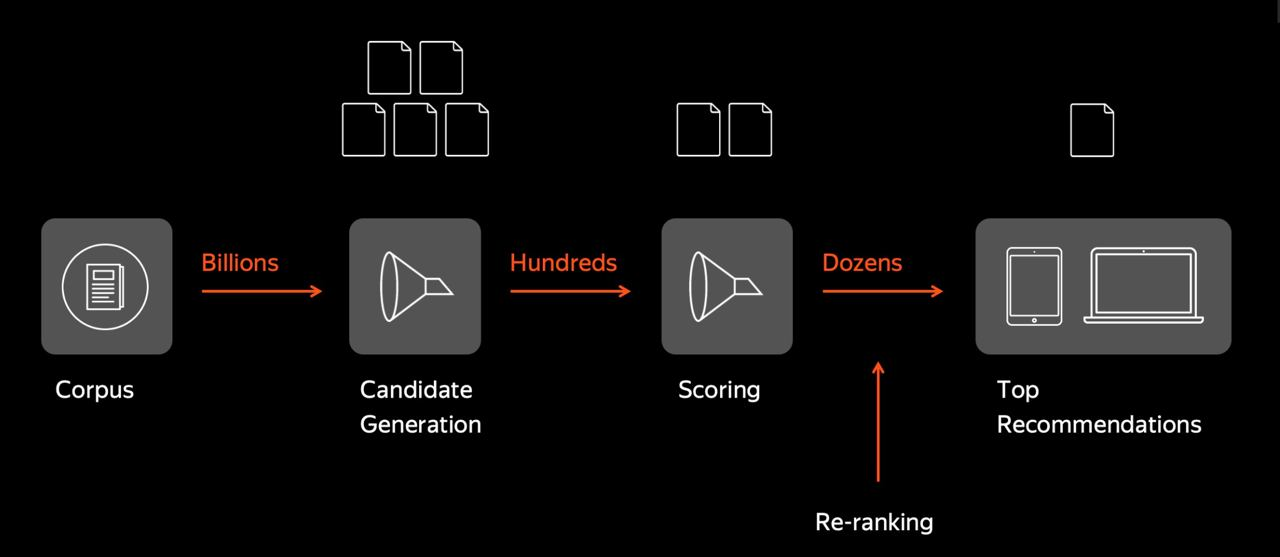 -->
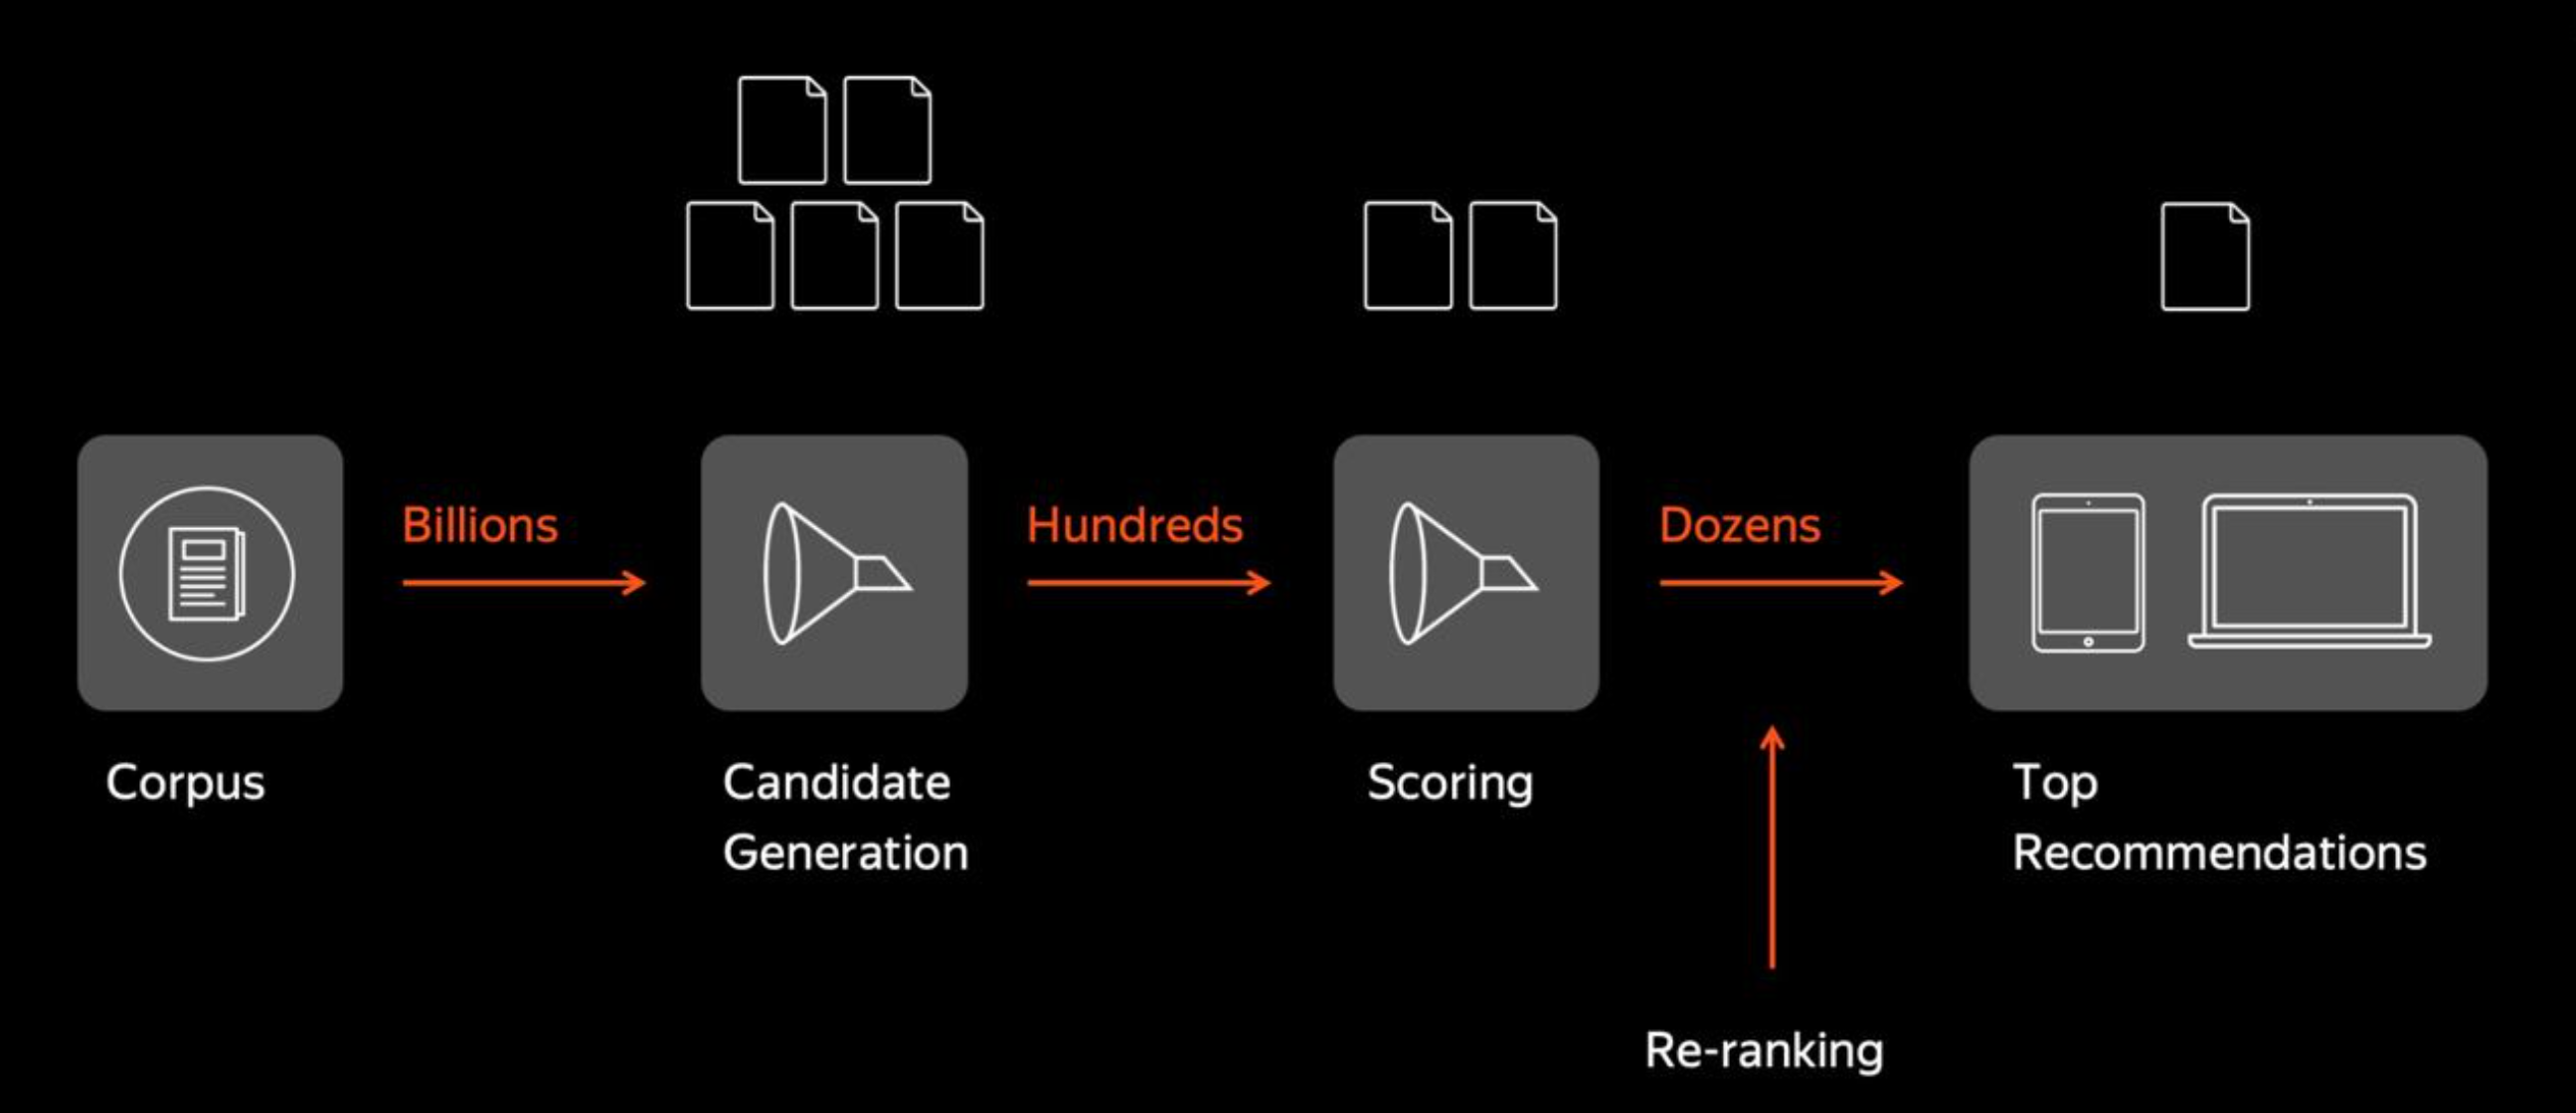

Приступим!

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
# визуализация

sns.set(style='darkgrid', palette='deep')
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['savefig.format'] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1.** Реализуем метрику $MAP@k$.

In [8]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    """
    Функция считает метрику оценивания ранжирования MAP@k в векторизованном виде.
    """
    # определяем счетчики
    ap_k, count = 0, 0
    # итерируемся по парам списков (y_relevant, y_predicted), если существует y_relevant
    for relevant_items, predicted_items in zip(relevant, predicted):
        if not relevant_items:
            continue
        # считаем вектор r_u(i) - относится ли i-й трек к релевантным 
        correct = np.isin(predicted_items[:k], relevant_items)
        # считаем AP_u@k
        # в np.cumsum(correct) / np.arange(1, k + 1) мы считаем вектор из всех p_u@k
        # домножая на correct вектор, мы получаем значение суммы из AP_u@k
        ap_k += np.sum(np.cumsum(correct) / np.arange(1, k + 1) * correct) / \
            min(k, len(relevant_items))  # нормируем AP_u@k на min(k, n_u)
        count += 1
    
    map_k = ap_k / count
    return map_k

In [10]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [11]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [12]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [13]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [14]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [15]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [16]:
ratings.shape, train_ratings.shape, test_ratings.shape, tracks_info.shape

((141454, 2), (129404, 2), (6133, 2), (67313, 3))

In [17]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [18]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [19]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2.** Реализуем родительский класс `BaseModel` для всех моделей ниже. Метод `get_test_recommendations` принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забудем удалять уже прослушанные треки из рекомендуемых.

In [20]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = np.array(preds[user_id])  # я добавил преобразование list в np.ndarray, т.к. иначе в строке ниже нельзя было сделать индексацию
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        # выдаем все рекомендации для каждого пользователя и собираем их в список
        test_preds_all = [self.recommend(user).tolist() for user in tqdm(range(self.n_users))]
        # удаляем уже прослушанные треки
        test_preds = self.remove_train_items(test_preds_all, k)

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2.** Реализуем функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей.

In [18]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    """
    Функция считает меру Жаккара (или IoU) в векторизованном виде.
    """
    # смотрим, у скольких юзеров совпали отметки: при умножении бинарных векторов получается 1
    intersection = np.sum(ratings * user_vector == 1, axis=1)
    # объединение - это пересечение выше плюс число несовпавших отметок
    union = intersection + np.sum(ratings != user_vector, axis=1)

    return intersection / union

Заметим: функцию похожести было бы **быстрее считать для всей матрицы юзеров**, а потом обращаться к нужному. Вот пример:

In [19]:
# имеющиеся данные
n_users = len(np.unique(ratings['userId']))
n_items = len(np.unique(ratings['trackId']))

R = np.zeros((n_users, n_items))
R[ratings['userId'], ratings['trackId']] = 1.

Допустим, найдем сходство между юзером с ID 1 и всеми остальными.

In [20]:
# наш юзер с ID 1
user_vector = R[1, :]
# только для одного юзера
jac_vec1 = jaccard(R, user_vector)

# в матричном виде для всех юзеров
intersection = R @ R.T
diagonal = intersection.diagonal()
jac = intersection / (
        np.expand_dims(diagonal, 0) + np.expand_dims(diagonal, -1) - intersection
    )
jac_vec2 = jac[1, :]

# они равны
np.all(jac_vec1 == jac_vec2)

True

In [51]:
%%timeit
jac_vec1 = jaccard(R, user_vector)

123 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
%%timeit
intersection = R @ R.T
diagonal = intersection.diagonal()
jac = intersection / (
        np.expand_dims(diagonal, 0) + np.expand_dims(diagonal, -1) - intersection
    )
jac_vec2 = jac[1, :]

47.6 ms ± 4.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Вывод**: второй вариант с умножением матриц работает **в 2-3 раза быстрее**, при этом мы также получаем близость для всех юзеров, а не только для одного.

Еще можно проверить корректность работы, сравнив нашу функцию с функцией из `sklearn`:

In [21]:
from sklearn.metrics import jaccard_score

jaccard_score(R[1, :], R[78, :]) == jaccard(R, user_vector)[78]

True

**Задание 4.** Реализуем методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [22]:
class User2User(BaseModel):
    def __init__(self, ratings, alpha=0.02):
        """
        User2User модель с мерой Жаккара в качестве функции похожести.
        """
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = alpha

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # получаем похожести со всеми юзерами
        similarity_all = self.similarity_func(self.R, user_vector)
        # получаем ID соседей
        # максимальную похожесть всегда будет иметь юзер сам с собой, поэтому убираем его
        similarity_idx = np.argsort(-similarity_all)[1:]
        
        return similarity_all, similarity_idx

    def recommend(self, uid: int):
        ### ищем соседей
        # забираем вектор оценок для нашего юзера
        user_vector = self.R[uid, :]
        # получаем похожести со всеми юзерами
        jac_vec, similarity_idx = self.similarity(user_vector)
        # забираем ID соседей из всех юзеров
        mask = jac_vec[similarity_idx] > self.alpha
        neighbours = similarity_idx[mask]  # это соседи

        ### получаем оценки для треков
        similarities = jac_vec[neighbours]  # похожесть с соседями юзера
        nom = np.sum(self.R[neighbours, :].T * similarities, axis=1)  # агрегируем их оценки
        denom = np.sum(similarities)  # нормировочная константа из формулы
        if denom == 0.0:
            r_hat = np.sum(self.R, axis=0)  # если похожих юзеров нет, выдадим самое популярное
        else:
            r_hat = nom / denom  # считаем предсказания рейтингов
        # получаем ID треков по убыванию скора
        best_items_idx = np.argsort(-r_hat)  

        return best_items_idx

**Задание 5.** Построим график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравним его с рекомендициями самых популярных треков и случайных и сделаем выводы.

In [23]:
num_users, num_tracks = ratings['userId'].unique().shape[0], ratings['trackId'].unique().shape[0]
k_s = np.arange(1, 51)

In [24]:
def remove_train_items(preds, k):
    """
    Функция основана на методе класса BaseModel.
    """
    new_preds = np.zeros((preds.shape[0], k), dtype=int)
    for user_id, user_data in train_ratings.groupby('userId'):
        user_preds = preds[user_id]
        new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data.trackId)][:k]
    
    return new_preds


# функции ниже основаны на семинаре 24 по МО-2
def random_prediction(k=10):
    preds = np.tile(np.arange(num_tracks), (num_users, 1))
    for i in tqdm(range(num_users)):
        rand_perm = np.random.permutation(num_tracks)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds


def top_prediction(k=10):
    R = np.zeros((num_users, num_tracks))
    R[train_ratings['userId'], train_ratings['trackId']] = 1.

    top_popular = np.argsort(-np.sum(R, axis=0))
    preds = np.tile(top_popular, (num_users, 1))
    preds = remove_train_items(preds, k=k)
    return preds

In [25]:
model = User2User(train_ratings)

In [26]:
test_predicted_u2u = model.get_test_recommendations(k_s[-1])
random_preds = random_prediction(k=k_s[-1])
top_preds = top_prediction(k=k_s[-1])

u2u_mapk = [mapk(test_relevant, test_predicted_u2u, k=k) for k in tqdm(k_s)]
random_mapk = [mapk(test_relevant, random_preds, k=k) for k in tqdm(k_s)]
top_mapk = [mapk(test_relevant, top_preds, k=k) for k in tqdm(k_s)]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

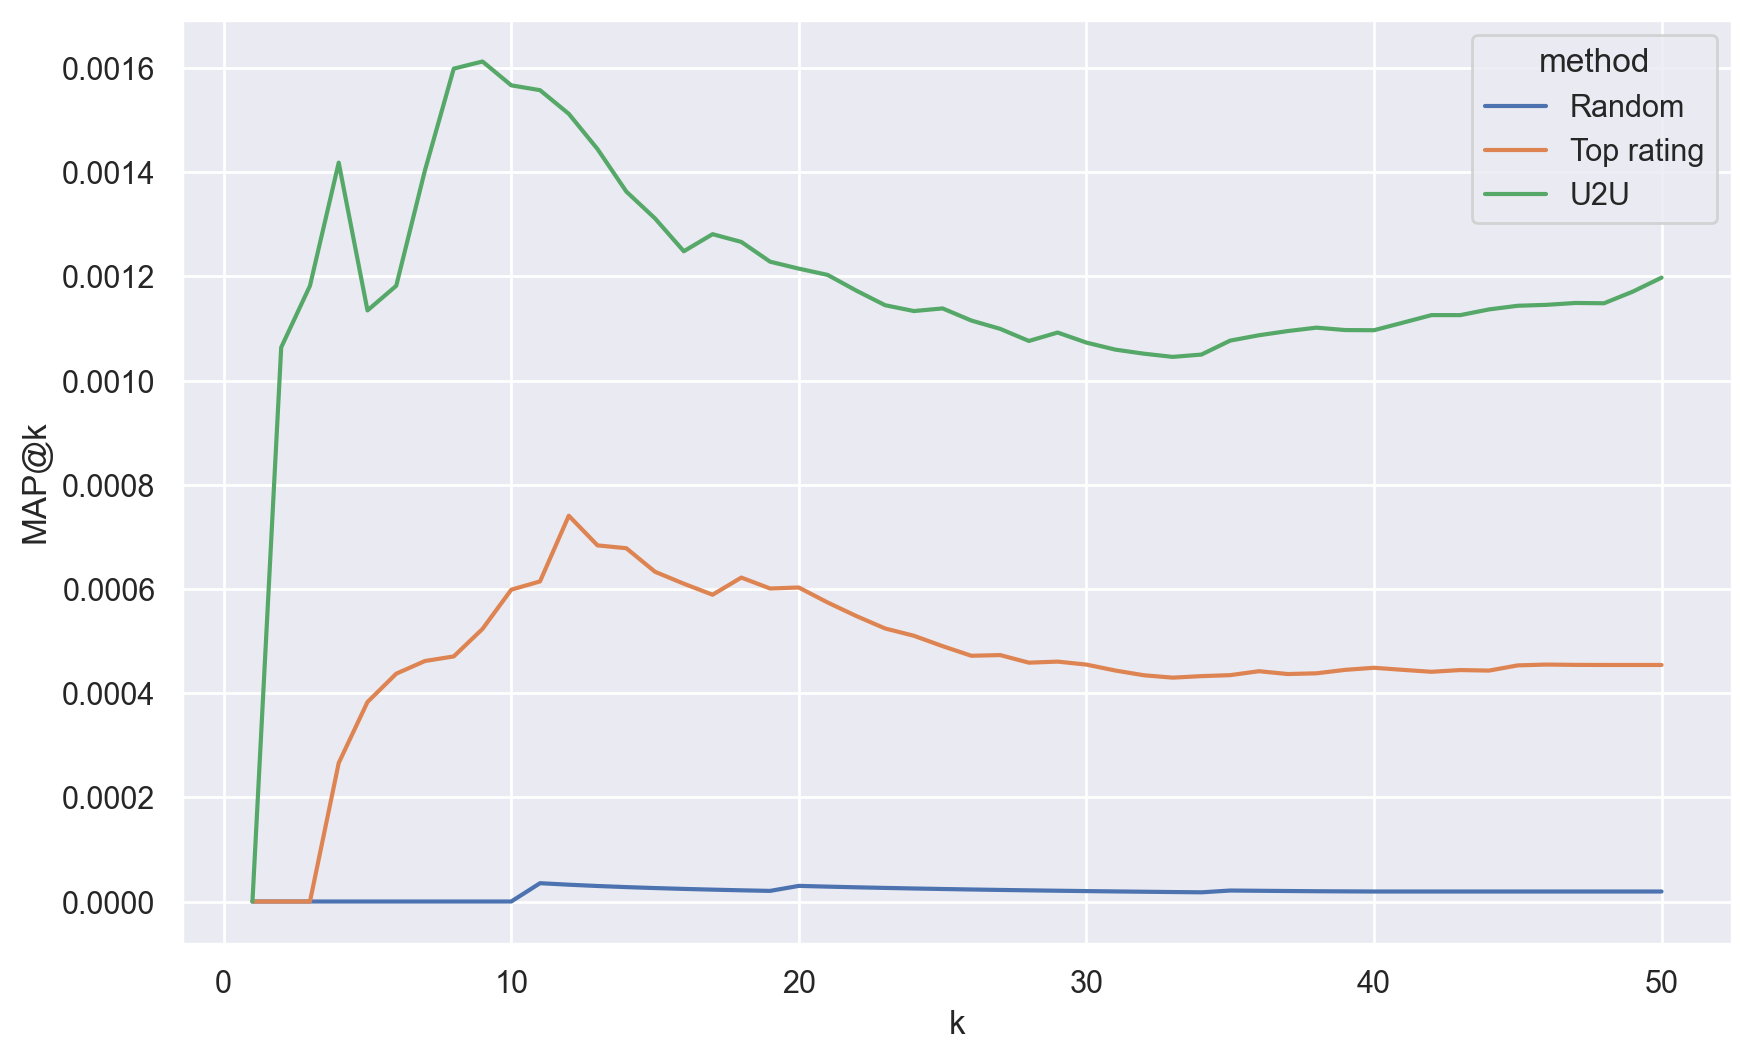

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, random_mapk, label='Random')
plt.plot(k_s, top_mapk, label='Top rating')
plt.plot(k_s, u2u_mapk, label='U2U')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

**Вывод**: модель `User2User` работает на порядок лучше, хотя метрика MAP@k все равно низкая, т.к. у нас очень много айтемов, и модель довольно слабая. Лучшее значение k — около 10.

**Бонус.** Можно заметить, что матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишем код так, чтобы все методы могли работать с разреженными матрицами и сравним скорость работы такого подхода с оригинальным.

In [29]:
def jaccard_sparse(ratings: np.array, user_vector: np.array) -> np.array:
    """
    Функция считает меру Жаккара (или IoU) в векторизованном виде
    для sparse-массивов.
    """
    # смотрим, у скольких юзеров совпали отметки: при умножении бинарных векторов получается 1
    intersection = np.sum(ratings * user_vector == 1, axis=1)
    # объединение - это пересечение выше плюс число несовпавших отметок
    # user_vector пришлось преобразовать из sparse в обычный вектор, т.к. иначе сравнение не работает
    union = intersection + np.sum(ratings != user_vector.toarray(), axis=1)

    return intersection / union

In [30]:
class User2UserSparse(BaseModel):
    def __init__(self, ratings, alpha=0.02):
        """
        User2User модель с мерой Жаккара в качестве функции похожести 
        и использованием сжатого формата хранения данных
        для матрицы взаимодействия users и items.
        """
        # я поменял init и не стал наследовать его от BaseModel
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        self.user_ids, self.item_ids = self.ratings.userId, self.ratings.trackId

        self.R = scs.coo_array((np.ones(self.user_ids.shape), (self.user_ids, self.item_ids)), shape=(self.n_users, self.n_items)).tocsr()

        self.similarity_func = jaccard_sparse
        self.alpha = alpha

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # получаем похожести со всеми юзерами
        similarity_all = self.similarity_func(self.R, user_vector)
        # получаем ID соседей
        # максимальную похожесть всегда будет иметь юзер сам с собой, поэтому убираем его
        similarity_idx = np.argsort(-similarity_all)[1:]
        
        return similarity_all, similarity_idx

    def recommend(self, uid: int):
        ### ищем соседей
        # забираем вектор оценок для нашего юзера
        user_vector = self.R[[uid], :]  # sparse-массивы не поддерживают 1-D срезы
        # получаем похожести со всеми юзерами
        jac_vec, similarity_idx = self.similarity(user_vector)
        # забираем ID соседей из всех юзеров
        mask = jac_vec[similarity_idx] > self.alpha
        neighbours = similarity_idx[mask]  # это соседи

        ### получаем оценки для треков
        similarities = jac_vec[neighbours]  # похожесть с соседями юзера
        nom = np.sum(self.R[neighbours, :].T * similarities, axis=1)  # агрегируем их оценки
        denom = np.sum(similarities)  # нормировочная константа из формулы
        if denom == 0.0:
            r_hat = np.sum(self.R, axis=0)  # если похожих юзеров нет, выдадим самое популярное
        else:
            r_hat = nom / denom  # считаем предсказания рейтингов
        # получаем ID треков по убыванию скора
        best_items_idx = np.argsort(-r_hat)  

        return best_items_idx

#### Сравнение

В начале проверим корректность работы `User2UserSparse`, затем — сравним работу `User2User` и `User2UserSparse` по времени и по памяти:

**Корректность**

In [31]:
sparse_model = User2UserSparse(train_ratings)

test_predicted_u2u_sparse = sparse_model.get_test_recommendations(k_s[-1])

  0%|          | 0/241 [00:00<?, ?it/s]

In [124]:
np.all(test_predicted_u2u_sparse == test_predicted_u2u), np.all(sparse_model.R.toarray() == model.R)  # все работает корректно

(True, True)

**Сравнение по памяти**

In [125]:
import sys

print(f'Обычная матрица, вес: {sys.getsizeof(model.R) / (1024 * 1024):.5f} Мб')
print(f'Sparse матрица,  вес: {sys.getsizeof(sparse_model.R) / (1024 * 1024):.5f} Мб')

Обычная матрица, вес: 123.76746 Мб
Sparse матрица,  вес: 0.00005 Мб


**Сравнение по времени**

In [127]:
%%time
test_predicted_u2u = model.get_test_recommendations(k_s[-1])

  0%|          | 0/241 [00:00<?, ?it/s]

CPU times: total: 33.3 s
Wall time: 33.7 s


In [126]:
%%time
test_predicted_u2u_sparse = sparse_model.get_test_recommendations(k_s[-1])

  0%|          | 0/241 [00:00<?, ?it/s]

CPU times: total: 23.9 s
Wall time: 24.3 s


In [134]:
(33.3 - 23.9) / 33.3

0.28228228228228225

**Итог**:
1. Обе модели *работают одинаково*.
2. Модель, работающая с разреженными матрицами, выдает предсказания примерно **на 30% быстрее** обычной модели.
3. Разница в занимаемой памяти очевидна: 123.8 Мб против **0.00005 Мб**.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у нас получилось?

In [37]:
user_id = np.random.randint(0, model.n_users)
user_id

187

In [38]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
231,Push The Feeling On,['Nightcrawlers']
842,Re-Align,['Godsmack']
843,I Stand Alone,['Godsmack']
872,Give It To Me,"['Timbaland', 'Justin Timberlake', 'Nelly Furt..."
900,Uhn Tiss Uhn Tiss Uhn Tiss,['Bloodhound Gang']
1552,Savior,['Rise Against']
2799,In the End,['Linkin Park']
2814,Numb,['Linkin Park']
2816,Don't Stay,['Linkin Park']
3217,Rock & Roll Queen,['The Subways']


In [39]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
1073,Smells Like Teen Spirit,['Nirvana']
805,Zombie,['The Cranberries']
24500,Way Down We Go,['KALEO']
11493,The Show Must Go On,['Queen']
1019,It's My Life,['Bon Jovi']
8263,Shape Of My Heart,['Sting']
7533,Highway to Hell,['AC/DC']
2555,Californication,['Red Hot Chili Peppers']
14763,Seven Nation Army,['The White Stripes']


In [40]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
61198,Astronomia,"['Alina Gingertail', 'Dryante']"
61708,Голодный пёс,"['SEEMEE', 'SODA LUV']"
62110,Tension,['HXVRMXN']
62457,АУФ,"['SQWOZ BAB', 'The First Station']"
62807,Ori Ori,['Manntra']
62836,After Dark,"['HXVRMXN', 'LxrdOfDoom']"
62959,Икры и Сала,['ДЕТИ RAVE']
63157,Что за бизнес сука?,['kizaru']
63286,Я буду ебать,"['Moreart', 'IHI']"
63375,San-fierro,"['SUCKED', ""Mc Blade'""]"


Исходя из того, что слушал пользователь раньше, рекомендации модели хорошие. Но песни, которые он слушал в действительности сильно отличаются по жанрам, поэтому фактически рекомендации не подходят.

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_i \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметим, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS.

**Задание 6.** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Ответ: если на каждом шаге оптимизации мы сэмплим существующую пару $(u, i)$ (заметим, что в такой постановке $r_{ui}$ всегда равен $1$, если пара $(u, i)$ существует), веса будут обновляться следующим образом.

Продифференцируем по $p_u$:
$$
\nabla_{p_u} \bigg[ (\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left( \|p_u\|^2 + \|q_i\|^2\right) \bigg] = (\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u.
$$

Тогда обновляем вектор $p_u$ по формуле:
$$
p_u := p_u - 2\eta (\langle p_u, q_i \rangle - r_{ui})q_i - 2\lambda p_u.
$$


Аналогично для $q_i$:
$$
q_i := q_i - 2\eta (\langle p_u, q_i \rangle - r_{ui})p_u - 2\lambda q_i.
$$


**ALS:**

Ответ: попеременно фиксируем матрицы $P$ и $Q$ и находим оптимальное решение для каждого столбца матрицы. В начале возьмем градиент по $p_u$ и приравняем к $0$:

$$
\nabla_{p_u} \bigg[ \sum_{u,i} (\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right) \bigg] =
$$
$$
= \sum_{i} 2(\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u = 0.
$$
	
Воспользовавшись тем, что $a^Tbc = cb^Ta$, получим:
$$
	\sum_{i} r_{ui}q_i - \sum_i q_i q_i^T p_u + 2\lambda p_u = 0.
$$

Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле:
$$
	p_u = \bigg( \sum_i q_i q_i^T\bigg)^{-1}\sum_ir_{ui}q_i - 2\lambda p_u \;\; \forall u,
$$
аналогично для столбцов матрицы $Q$:
$$
	q_i = \bigg( \sum_u p_u p_u^T\bigg)^{-1}\sum_ur_{ui}p_u - 2\lambda q_i \;\; \forall i.
$$



**Задание 7.** Реализуем методы оптимизации параметров для обоих алгоритмов.

In [33]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, val=False, val_ratings=None, dim=128, mode='sgd', lr=0.0003, lamb=0.01, eps=1e-7, seed=42):
        """
        Модель Latent Factor Model с оптимизацией с помощью SGD или ALS и регуляризацией,
        а также возможностью валидации на обучающей и тестовой выборках.
        """
        super().__init__(ratings)
        self.user_ids, self.item_ids = ratings.userId, ratings.trackId
        self.dim = dim
        self.seed = seed
        self.eps = eps
        self.val = val
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        if self.val:
            assert val_ratings is not None
            self.val_ratings = val_ratings
        
        np.random.seed(seed)
        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = lr
        self.lamb = lamb

    def fit(self, num_iters=5, verbose_sgd=100, verbose_epoch=1000):
        # фиксируем сид
        np.random.seed(self.seed)
        # заводим списки для логов
        train_loss_history_full = []
        mean_loss_ = []
        total_mean_loss = []
        train_epoch_loss = []
        val_epoch_loss = []
        best_k_s, best_mapk_s = [], []

        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                # семплим юзера и айтем так, чтобы такая пара существовала, т.к. LFM работает с явной информацией
                u = np.random.randint(0, self.n_users)
                i = np.random.choice(np.where(self.R[u] == 1)[0])
                assert self.R[u, i] == 1.  # в любом случае, каждое взаимодействие будет равно 1
                # считаем лосс
                loss = (self.P[u] @ self.Q[i] - self.R[u, i]) ** 2
                # обновляем векторы p_u и q_i
                self.P[u] = self.P[u] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.Q[i] - self.lamb * 2 * self.P[u]
                self.Q[i] = self.Q[i] - self.lr * 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.P[u] - self.lamb * 2 * self.Q[i]
                # лагируем
                train_loss_history_full.append(np.sqrt(loss))  # беру корень для интерпретируемости
                mean_loss_.append(loss)

                if epoch % verbose_sgd == 0:
                    # считаем средний лосс
                    total_mean_loss.append(np.sqrt(sum(mean_loss_) / len(mean_loss_)))
                    mean_loss_ = []

                if self.val:
                    if epoch % verbose_epoch == 0:
                        # считаем лосс на всей обуч. и тестовой выборках
                        train_preds_sgd = (self.P[self.ratings.userId] * self.Q[self.ratings.trackId]).sum(axis=1)
                        # ради интереса можно сравнить лосс по обычным предсказаниям и обрезанным до интервала [0, 1]
                        train_preds_sgd_cliped = np.clip(train_preds_sgd, 0.0, 1.0)
                        train_epoch_loss.append((np.sqrt(np.mean((train_preds_sgd - 1) ** 2)), np.sqrt(np.mean((train_preds_sgd_cliped - 1) ** 2))))

                        val_preds_sgd = (self.P[self.val_ratings.userId] * self.Q[self.val_ratings.trackId]).sum(axis=1)
                        val_preds_sgd_cliped = np.clip(val_preds_sgd, 0.0, 1.0)
                        val_epoch_loss.append((np.sqrt(np.mean((val_preds_sgd - 1) ** 2)), np.sqrt(np.mean((val_preds_sgd_cliped - 1) ** 2))))
                        # считаем map@k
                        preds = self.get_test_recommendations(k_s[-1])
                        lfm_sgd_mapk = [mapk(test_relevant, preds, k=k) for k in k_s]

                        best_mapk_sgd_k_idx = np.argmax(np.array(lfm_sgd_mapk))
                        best_mapk_sgd_k = k_s[best_mapk_sgd_k_idx]
                        best_k_s.append(best_mapk_sgd_k)
                        best_mapk_sgd = lfm_sgd_mapk[best_mapk_sgd_k_idx]
                        best_mapk_s.append(best_mapk_sgd)
                    

            elif self.mode == 'als':
                # поочередно обновляем матрицы P и Q, фиксируя их
                RQ = self.R @ self.Q
                for u in tqdm(range(self.n_users)):
                    relevant_items = self.item_ids[self.user_ids == u]
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.eps * np.eye(self.dim)) @ RQ[u] - self.lamb * 2 * self.P[u]

                RP = R.T @ self.P
                for i in tqdm(range(self.n_items)):
                    relevant_users = self.user_ids[self.item_ids == i]
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.eps * np.eye(self.dim)) @ RP[i] - self.lamb * 2 * self.Q[i]

                if self.val:
                    # валидация
                    train_preds_als = (self.P[self.ratings.userId] * self.Q[self.ratings.trackId]).sum(axis=1)
                    train_preds_als_cliped = np.clip(train_preds_als, 0.0, 1.0)
                    train_epoch_loss.append((np.sqrt(np.mean((train_preds_als - 1) ** 2)), np.sqrt(np.mean((train_preds_als_cliped - 1) ** 2))))

                    val_preds_als = (self.P[self.val_ratings.userId] * self.Q[self.val_ratings.trackId]).sum(axis=1)
                    val_preds_als_cliped = np.clip(val_preds_als, 0.0, 1.0)
                    val_epoch_loss.append((np.sqrt(np.mean((val_preds_als - 1) ** 2)), np.sqrt(np.mean((val_preds_als_cliped - 1) ** 2))))
                    # считаем map@k
                    preds = self.get_test_recommendations(k_s[-1])
                    lfm_als_mapk = [mapk(test_relevant, preds, k=k) for k in k_s]

                    best_mapk_als_k_idx = np.argmax(np.array(lfm_als_mapk))
                    best_mapk_als_k = k_s[best_mapk_als_k_idx]
                    best_k_s.append(best_mapk_als_k)
                    best_mapk_als = lfm_als_mapk[best_mapk_als_k_idx]
                    best_mapk_s.append(best_mapk_als)

        return train_loss_history_full, total_mean_loss, train_epoch_loss, val_epoch_loss, best_mapk_s, best_k_s

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8.** Подберем оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$ для обоих алгоритмов. Посмотрим, как изменяется качество предсказаний с числом итераций обучения — построим соответствующие графики, сравним со случайным подхом и User2User, сделаем выводы. Определим, какой алгоритм кажется более подходящим для данной задачи и почему.

#### SGD

Переберем значения размерности скрытого пространства `dim` по логарифмической шкале, а также размер предсказания `k` от 1 до 50.

SGD обучается быстро, поэтому можно обучать его по 1 млн. итераций каждый раз.

In [34]:
from IPython.display import clear_output
import time

SGD_NUM_ITERS = 1_000_000

dims = np.logspace(2, 9, base=2, num=8, dtype=int)
dims

array([  4,   8,  16,  32,  64, 128, 256, 512])

In [123]:
timer = []
best_k_s_sgd, best_mapk_s_sgd = [], []
mapk_s_sgd_all, k_s_sgd_all = [], []
train_loss_history_sgd_all, total_mean_loss_sgd_all = [], []
train_epoch_loss_agd_all, val_epoch_loss_agd_all = [], []
count = 0

for dim in dims:
    print(f'Model {count + 1} from {len(dims)}, dim={dim}')
    # обучаем модель
    LFM_SGD = LatentFactorModel(train_ratings, val=True, val_ratings=test_ratings, dim=dim, lr=0.0003 / 2, lamb=0.01 / 2, mode='sgd')
    start = time.time()
    train_loss_history_full, total_mean_loss, train_epoch_loss, val_epoch_loss, best_mapk_s, best_k_s = LFM_SGD.fit(SGD_NUM_ITERS, 
                                                                                                                    verbose_sgd=10000,
                                                                                                                    verbose_epoch=20000)
    timer.append(time.time() - start)

    # добавляем лучшее MAP@k
    best_mapk_idx = np.argmax(np.array(best_mapk_s))
    best_mapk = best_mapk_s[best_mapk_idx]
    best_k = best_k_s[best_mapk_idx]

    best_mapk_s_sgd.append(best_mapk)
    best_k_s_sgd.append(best_k)
    # лагируем лосс и другие результаты обучения
    mapk_s_sgd_all.append(best_mapk_s)
    k_s_sgd_all.append(best_k_s)
    train_loss_history_sgd_all.append(train_loss_history_full)
    total_mean_loss_sgd_all.append(total_mean_loss)
    train_epoch_loss_agd_all.append(train_epoch_loss)
    val_epoch_loss_agd_all.append(val_epoch_loss)
    # очищаем выдачу, идем дальше
    clear_output()
    count += 1

In [145]:
# время в секундах, которое заняло полное обучение
timer

[360.8242301940918,
 337.32567596435547,
 339.8114924430847,
 353.508437871933,
 396.4248802661896,
 387.7571527957916,
 412.2065317630768,
 558.1825034618378]

**Визуализация результатов**

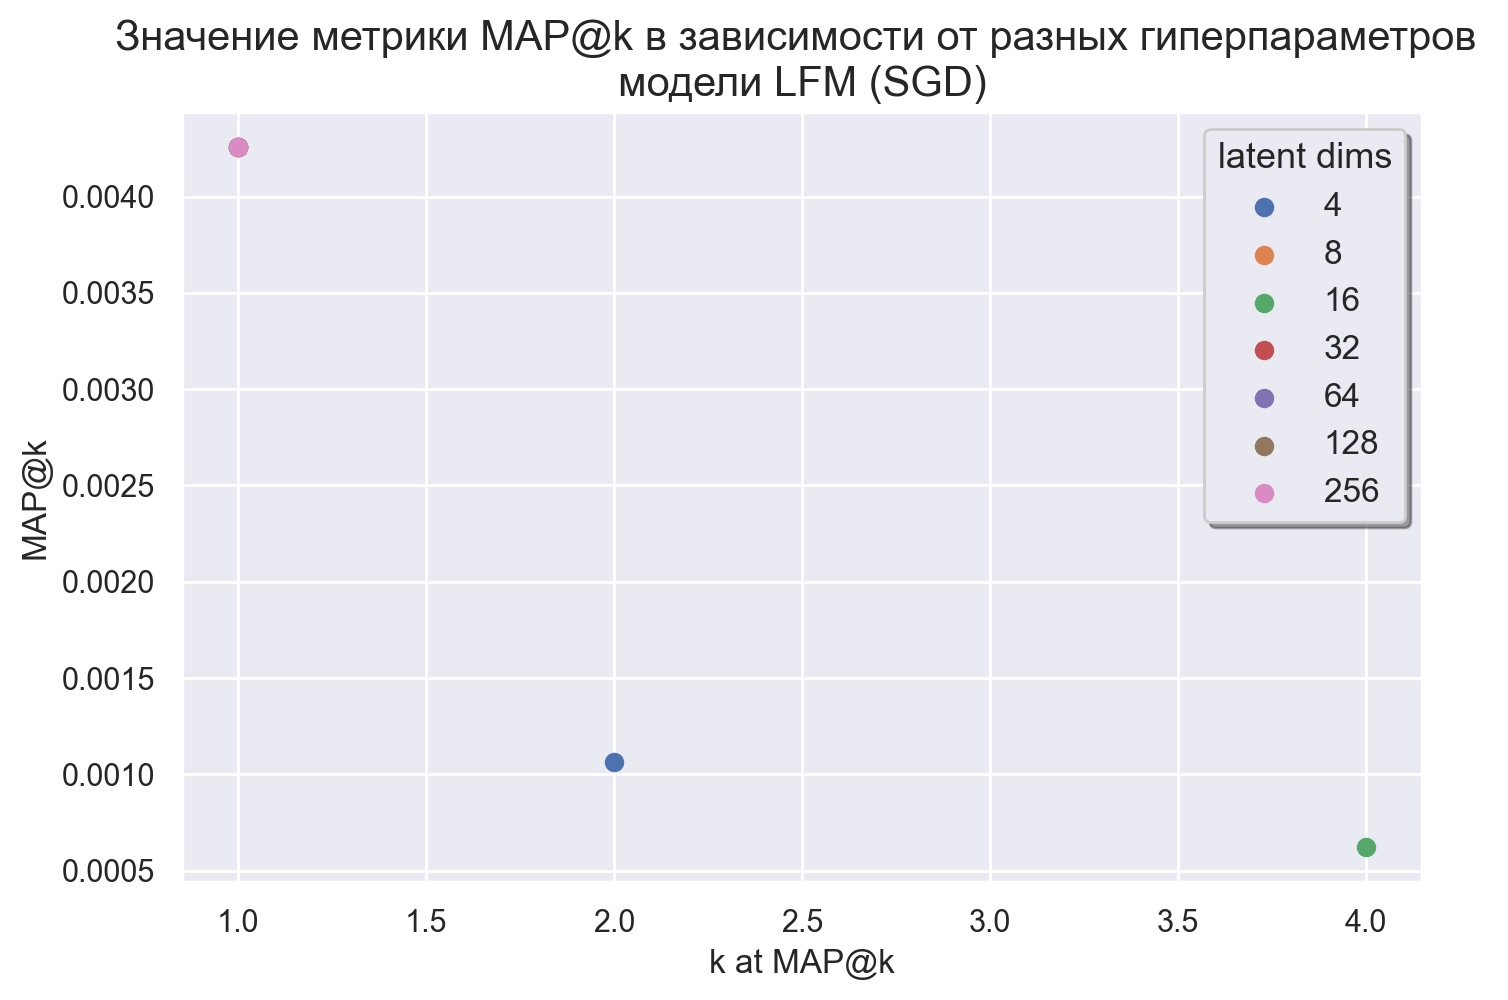

In [124]:
plt.figure(figsize=(8, 5))

for i in range(len(dims) - 1):
    plt.scatter(best_k_s_sgd[i], best_mapk_s_sgd[i], label=str(dims[i]))

plt.legend(title='latent dims', title_fontsize=13, fontsize=12, loc='best', shadow=True)
plt.xlabel('k at MAP@k')
plt.ylabel('MAP@k')
plt.title('Значение метрики MAP@k в зависимости от разных гиперпараметров \nмодели LFM (SGD)', fontsize=15);

На самом деле, точки на графике слиплись в одну в некоторых местах. Лучше продемонстрировать результат так:

In [126]:
best_mapk_s_sgd

[0.0010638297872340426,
 0.00425531914893617,
 0.0006205673758865247,
 0.00425531914893617,
 0.00425531914893617,
 0.00425531914893617,
 0.00425531914893617,
 0.00425531914893617]

In [143]:
for i in range(len(mapk_s_sgd_all)):
    print(f'best iter = {np.argmax(np.array(mapk_s_sgd_all[i])) * 20000}, k = {best_k_s_sgd[i]}, dim = {dims[i]}')

best iter = 480000, k = 2, dim = 4
best iter = 520000, k = 1, dim = 8
best iter = 380000, k = 4, dim = 16
best iter = 220000, k = 1, dim = 32
best iter = 200000, k = 1, dim = 64
best iter = 520000, k = 1, dim = 128
best iter = 440000, k = 1, dim = 256
best iter = 140000, k = 1, dim = 512


Остановимся на размерности **64**, как требующей наименьшее число итераций, т.к. время обучения у всех моделей до размерности 256 примерно одинаковое.

Вот как шло обучение модели со скрытой размерностью 64:

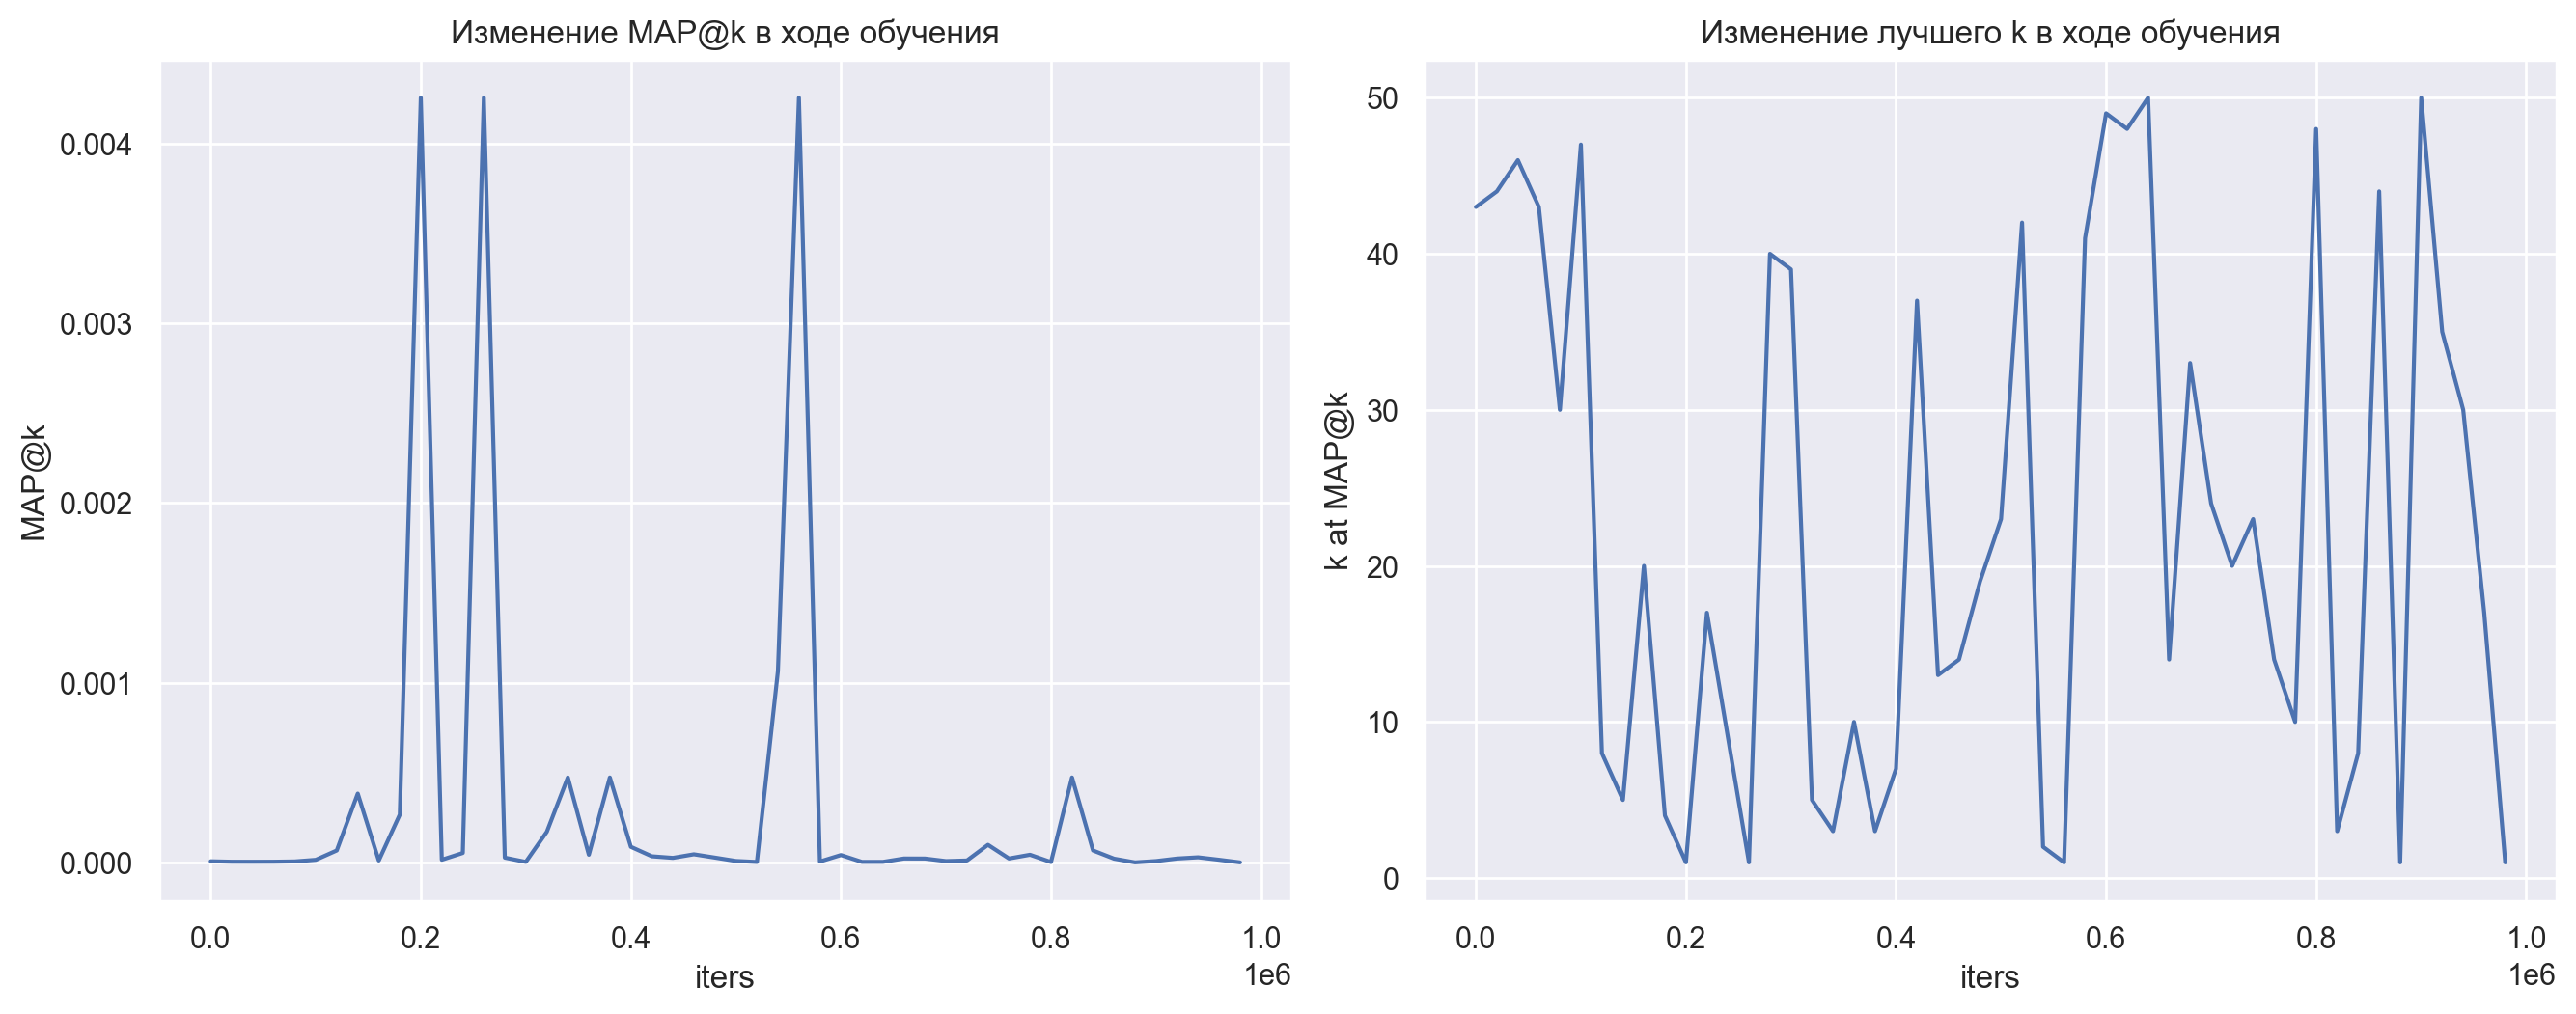

In [157]:
f, ax0 = plt.subplots(1, 2, figsize=(15,6), sharex=True, sharey=False)

ax0[0].plot(list(range(0, SGD_NUM_ITERS, 20000)), mapk_s_sgd_all[4])
ax0[0].set_ylabel('MAP@k')
ax0[0].set_xlabel('iters')
ax0[0].set_title('Изменение MAP@k в ходе обучения')

ax0[1].plot(list(range(0, SGD_NUM_ITERS, 20000)), k_s_sgd_all[4])
ax0[1].set_ylabel('k at MAP@k')
ax0[1].set_xlabel('iters')
ax0[1].set_title('Изменение лучшего k в ходе обучения')

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

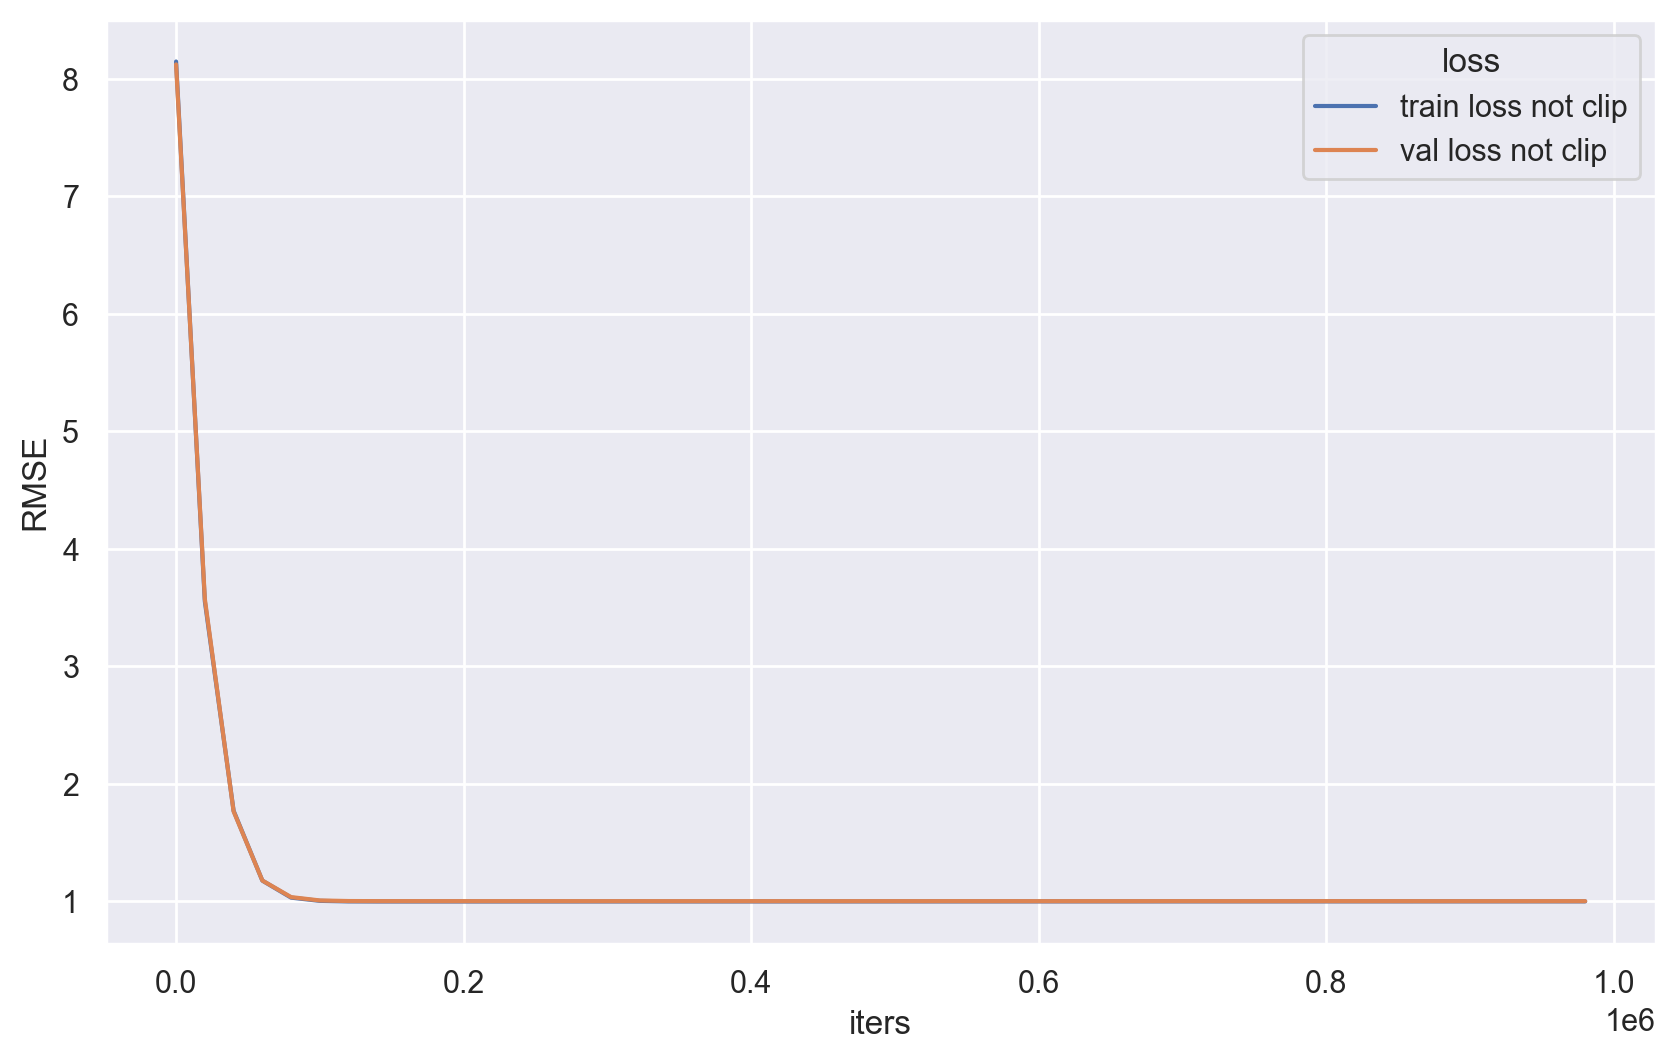

In [169]:
# можно раскомментировать разные графики и посмотреть на более подробные результаты

plt.figure(figsize=(10, 6))
# plt.plot(list(range(SGD_NUM_ITERS)), train_loss_history_sgd_all[4], label='train loss full history')
# plt.plot(list(range(0, SGD_NUM_ITERS, 10000)), total_mean_loss_sgd_all[4], label='mean loss last 10 000')
plt.plot(list(range(0, SGD_NUM_ITERS, 20000)), [elem[0] for elem in train_epoch_loss_agd_all[4]], label='train loss not clip')
# plt.plot(list(range(0, SGD_NUM_ITERS, 20000)), [elem[1] for elem in train_epoch_loss_agd_all[4]], label='train loss with clip')
plt.plot(list(range(0, SGD_NUM_ITERS, 20000)), [elem[0] for elem in val_epoch_loss_agd_all[4]], label='val loss not clip')
# plt.plot(list(range(0, SGD_NUM_ITERS, 20000)), [elem[1] for elem in val_epoch_loss_agd_all[4]], label='val loss with clip')

plt.legend(title='loss')
plt.xlabel('iters')
plt.ylabel('RMSE')
plt.show()

Заметим:
* лосс быстро спускается до значения 1, т.к. LFM с SGD склонен предсказывать околонулевые значения (сила регуляризации и ее наличие в целом не влияет на это — выявлено в ходе экспериментов),
* качество рекомендаций сильно скачет в ходе обучения. Но, в целом, SGD не требует большого числа итераций, что, безусловно, положительно сказывается на скорости обучения.

Теперь обучим **итоговый алгоритм** LFM с помощью SGD:

In [35]:
LFM_SGD_best = LatentFactorModel(train_ratings, val=False, dim=64, lr=0.0003 / 2, lamb=0.01 / 2, mode='sgd')

train_loss_history_full_sgd, total_mean_loss_sgd, train_epoch_loss_sgd, val_epoch_loss_sgd, best_mapk_s_sgd, best_k_s_sgd = LFM_SGD_best.fit(200_000, 
                                                                                                                                        verbose_sgd=10000)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [36]:
lfm_sgd_preds = LFM_SGD_best.get_test_recommendations(k_s[-1])
lfm_sgd_mapk = [mapk(test_relevant, lfm_sgd_preds, k=k) for k in tqdm(k_s)]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

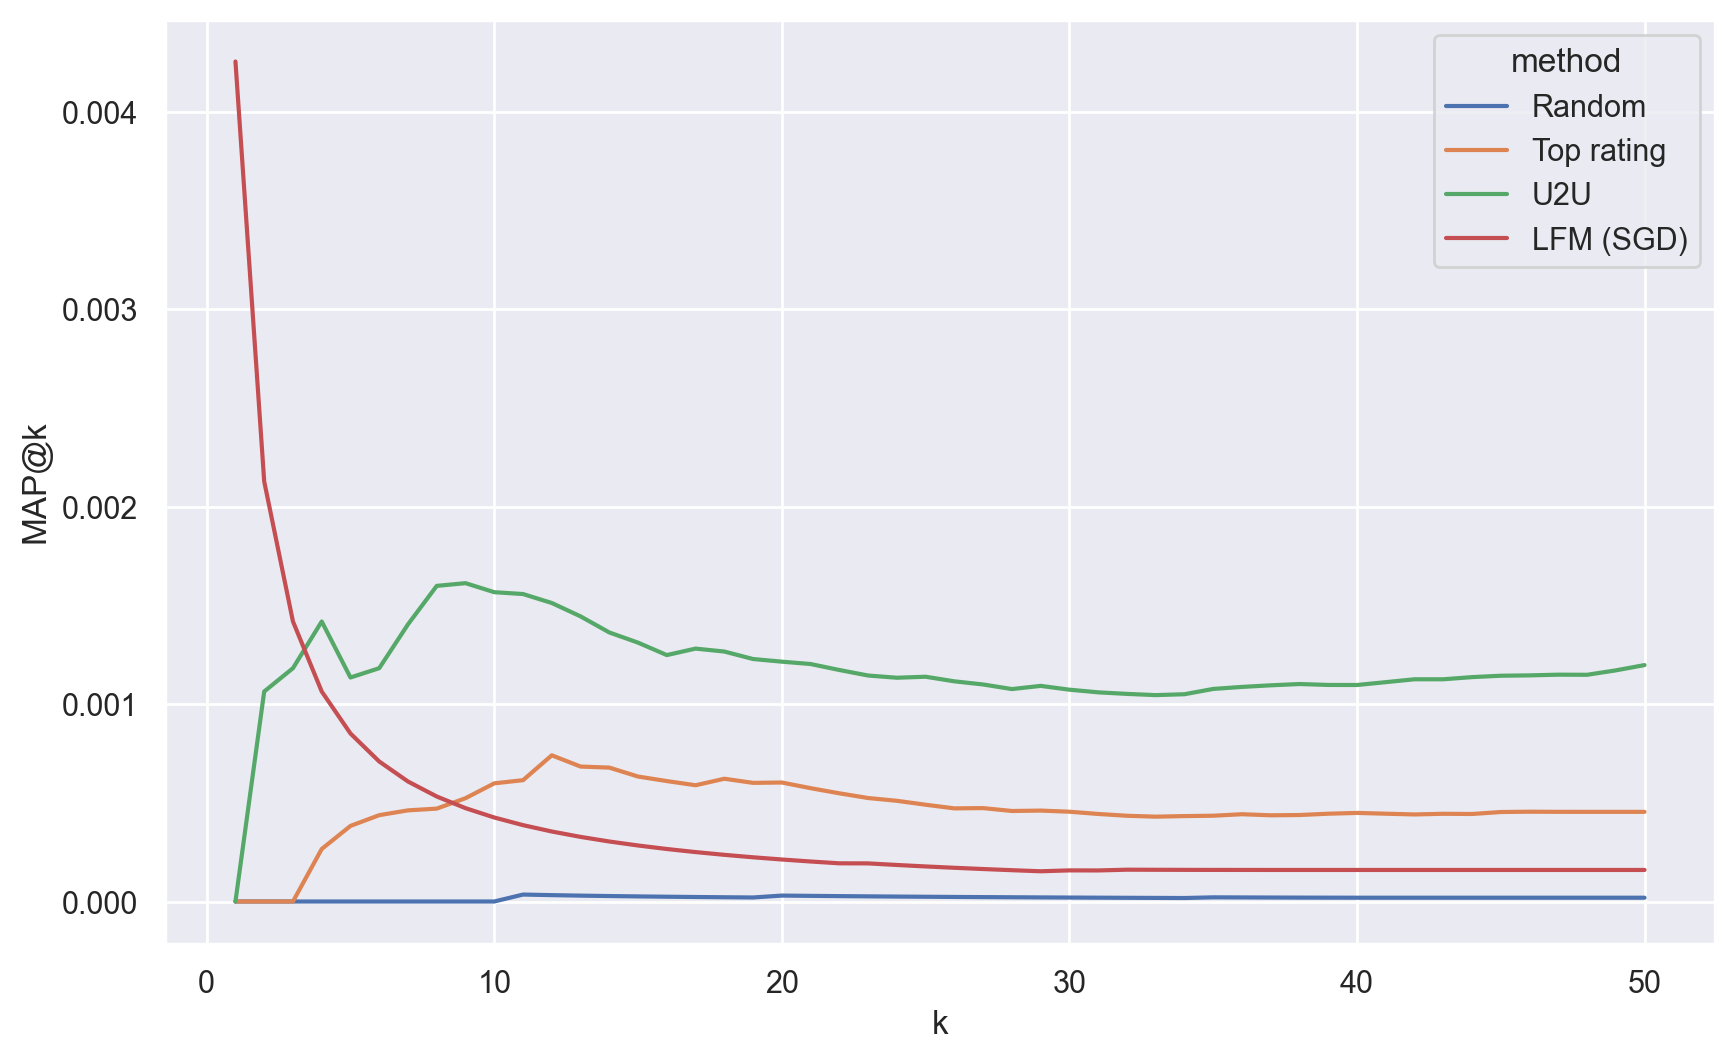

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, random_mapk, label='Random')
plt.plot(k_s, top_mapk, label='Top rating')
plt.plot(k_s, u2u_mapk, label='U2U')
plt.plot(k_s, lfm_sgd_mapk, label='LFM (SGD)')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

LFM с SGD обошел по качеству ранжирования предыдущие модели на небольших значениях `k`, но проигрывает при больших `k`.

Вот как выглядел лосс при обучении:

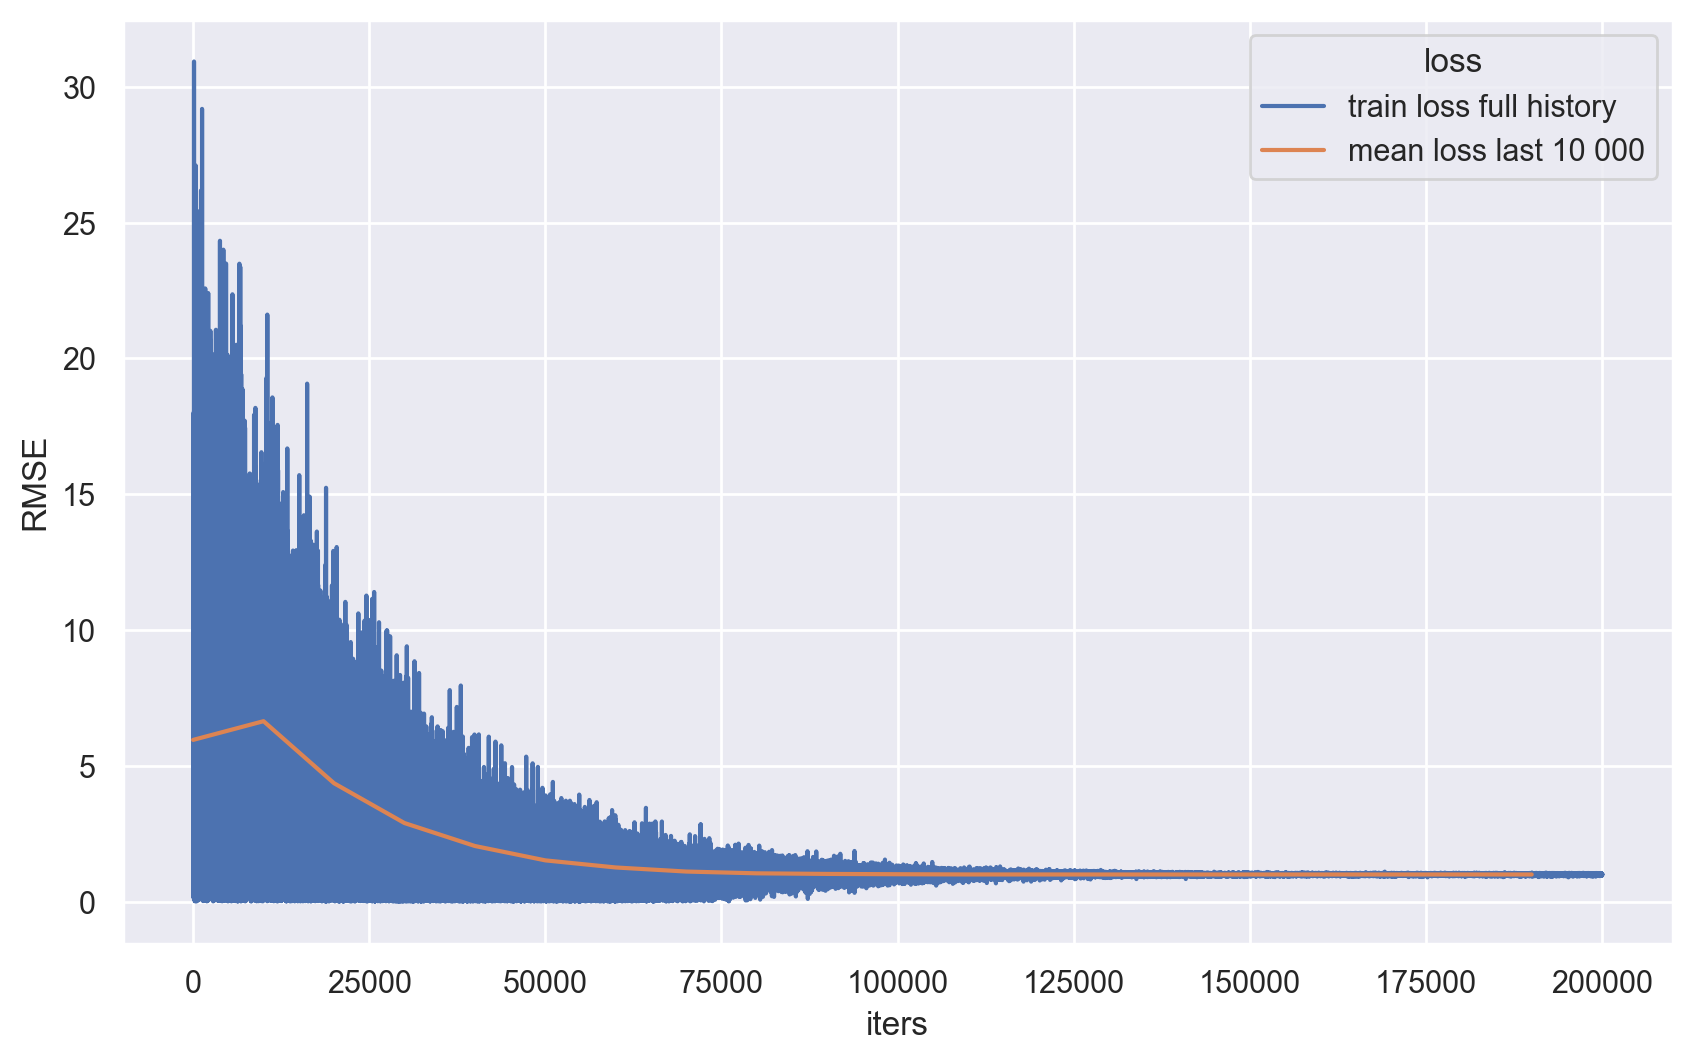

In [174]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(200_000)), train_loss_history_full_sgd, label='train loss full history')
plt.plot(list(range(0, 200_000, 10000)), total_mean_loss_sgd, label='mean loss last 10 000')

plt.legend(title='loss')
plt.xlabel('iters')
plt.ylabel('RMSE')
plt.show()

#### ALS

Аналогично пункту выше я попробую подобрать параметры `dim` и `k`. Но теперь я буду обучаться одну эпоху, т.е. обновлять столбцы матриц P и Q по одному разу, т.к. ALS работает гораздо дольше, особенно при больших скрытых размерностях.

In [177]:
# не беру 512, т.к. это слишком большая размерность для ALS с обращением матриц
dims = np.logspace(2, 8, base=2, num=7, dtype=int)
dims

array([  4,   8,  16,  32,  64, 128, 256])

In [66]:
ALS_NUM_ITERS = 1

timer = []
best_k_s_als = []
best_mapk_s_als = []
train_epoch_loss_als_all, val_epoch_loss_als_all = [], []
count = 0

for dim in dims:
    print(f'Model {count + 1} from {len(dims)}, dim={dim}')
    # обучаем модель
    LFM_ALS = LatentFactorModel(train_ratings, val=True, val_ratings=test_ratings, dim=dim, lamb=0.01 / 2, mode='als')
    start = time.time()
    _, _, train_epoch_loss_als, val_epoch_loss_als, _, _ = LFM_ALS.fit(ALS_NUM_ITERS)
    timer.append(time.time() - start)

    train_epoch_loss_als_all.append(train_epoch_loss_als)
    val_epoch_loss_als_all.append(val_epoch_loss_als)

    # считаем map@k
    lfm_als_preds = LFM_ALS.get_test_recommendations(k_s[-1])
    lfm_als_mapk = [mapk(test_relevant, lfm_als_preds, k=k) for k in tqdm(k_s)]

    best_mapk_als_k_idx = np.argmax(np.array(lfm_als_mapk))
    best_mapk_als_k = k_s[best_mapk_als_k_idx]
    best_k_s_als.append(best_mapk_als_k)
    best_mapk_als = lfm_als_mapk[best_mapk_als_k_idx]
    best_mapk_s_als.append(best_mapk_als)

    # очищаем выдачу
    clear_output()
    count += 1

Время работы:

In [90]:
timer

[35.13303184509277,
 34.43934154510498,
 39.84848594665527,
 65.5368504524231,
 331.39776134490967,
 414.6272723674774,
 830.0539619922638]

**Визуализация результатов:**

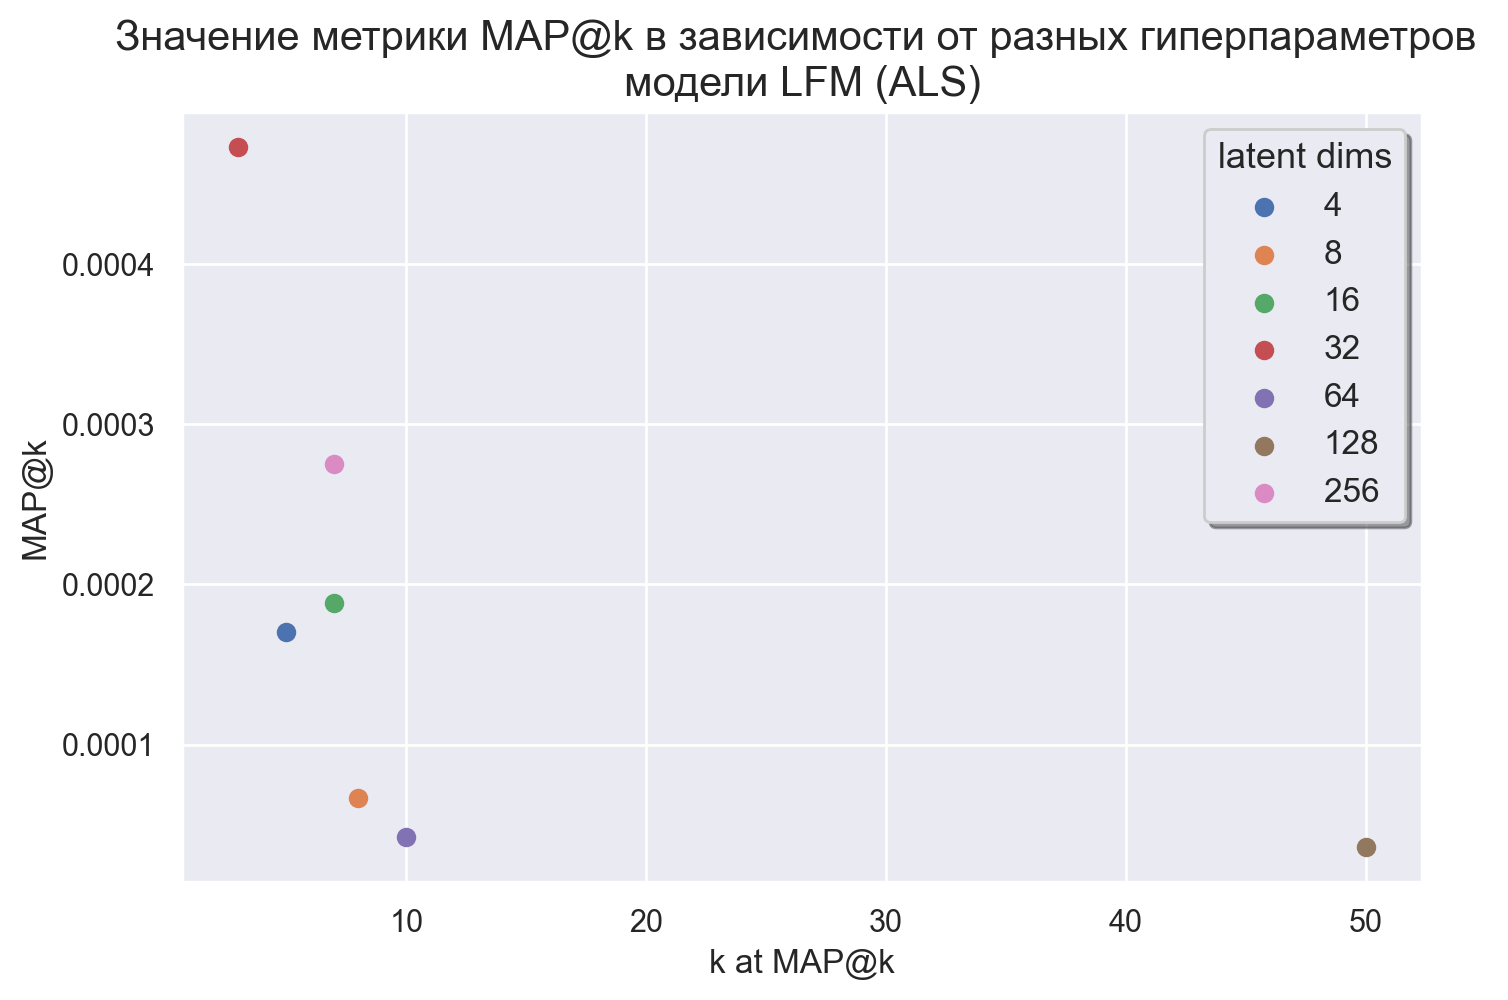

In [64]:
plt.figure(figsize=(8, 5))

for i in range(len(dims) - 1):
    plt.scatter(best_k_s_als[i], best_mapk_s_als[i], label=str(dims[i]))

plt.legend(title='latent dims', title_fontsize=13, fontsize=12, loc='best', shadow=True)
plt.xlabel('k at MAP@k')
plt.ylabel('MAP@k')
plt.title('Значение метрики MAP@k в зависимости от разных гиперпараметров \nмодели LFM (ALS)', fontsize=15);

Возьмем размерность скрытого пространства **32**: с ней LFM быстро учится и выдает неплохое качество.

Но нужно заметить, что лучшее качество рекомендаций снова получается при небольших `k`. Если нам нужно выдавать большое число рекомендаций, стоит присмотреться к `dim`, равному 256 (однако тогда модель долго учится).

Обучим итоговый алгоритм LFM с ALS:

In [38]:
LFM_ALS = LatentFactorModel(train_ratings, val=True, val_ratings=test_ratings, dim=32, lamb=0.01 / 2, mode='als')
_, _, train_epoch_loss_als, val_epoch_loss_als, best_mapk_s_als, best_k_s_als = LFM_ALS.fit(4)

clear_output()

In [39]:
lfm_als_preds = LFM_ALS.get_test_recommendations(k_s[-1])
lfm_als_mapk = [mapk(test_relevant, lfm_als_preds, k=k) for k in tqdm(k_s)]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

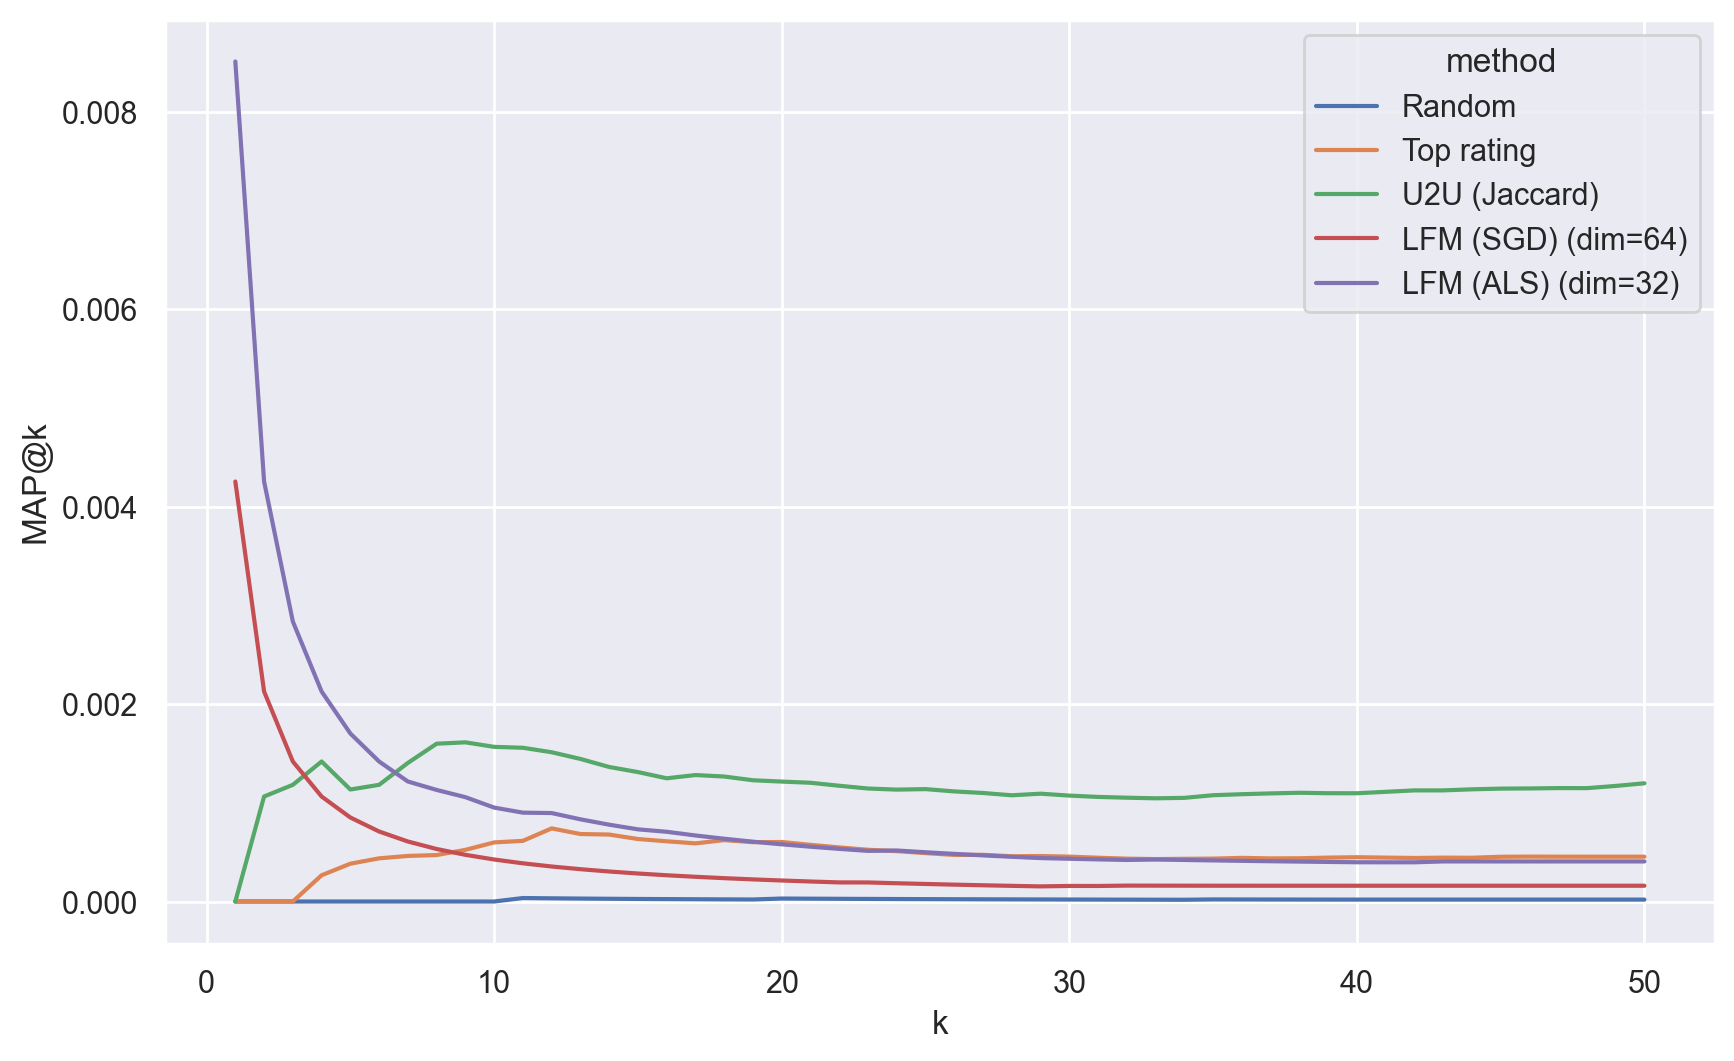

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, random_mapk, label='Random')
plt.plot(k_s, top_mapk, label='Top rating')
plt.plot(k_s, u2u_mapk, label='U2U (Jaccard)')
plt.plot(k_s, lfm_sgd_mapk, label='LFM (SGD) (dim=64)')
plt.plot(k_s, lfm_als_mapk, label='LFM (ALS) (dim=32)')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

**Итог**: Лучшее качество рекомендаций показывает модель LFM, причем версия с ALS лучше, чем версия с SGD, хотя, конечно, ALS обучается дольше SGD.

Однако модель LFM показала лучшее качество при небольших значениях `k` — числе рекомендаций. Если работа сервиса предполагает выдачу большого числа треков пользователю при рекомендации (например, целый плейлист), то для этой задачи я бы выбрал модель User2User, которая показывает лучшее качество при больших `k`.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [335]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = LFM_ALS.Q @ LFM_ALS.Q[example_trackId]
preds = preds / np.sqrt((LFM_ALS.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [336]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(LFM_ALS.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.726321
5570,Моё сердце,['Сплин'],0.672086
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.671403
17811,На заре,['Альянс'],0.667524
16224,Пока горит свеча,['Машина времени'],0.652768
26075,Лошадка,['Найк Борзов'],0.650422
9689,Bicycle Race,['Queen'],0.640296
16637,Zodiac,['Zodiac'],0.640296
5153,Stormbringer,['Deep Purple'],0.640296


### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9.**

Для каждого пользователя возьмем топ-100 рекомендованных треков от модели LFM (ALS или SGD) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [41]:
def create_candidates():
    test_predicted_u2u_100 = model.get_test_recommendations(100)
    lfm_als_preds_100 = LFM_ALS.get_test_recommendations(100)
    candidates_200 = np.hstack((test_predicted_u2u_100, lfm_als_preds_100))
    assert candidates_200.shape[1] == 200
    return candidates_200

In [42]:
candidates = create_candidates()

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

In [43]:
# mapk без переранжирования (фактически для U2U, т.к. ее кандидаты первые)
mapk(test_relevant, candidates, k=20)

0.0012149358904348692

**Задание 10.**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разобьем полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [44]:
import scipy
from tqdm import tqdm as tqdm_old
from sklearn.model_selection import train_test_split

Небольшая подготовительная работа: предпосчитаем признаки для юзеров и айтемов из пунктов 4-6:

In [45]:
def create_mean_similarities():
    res = []
    for uid in tqdm(range(model.n_users)):
        similarity_all, similarity_idx = model.similarity(model.R[uid, :])
        res.append(np.mean(similarity_all[similarity_idx]))
    
    return res

similarities_mean = create_mean_similarities()
user_listen_rate = np.sum(model.R, axis=0) / model.R.shape[0]
user_track_number = np.sum(model.R, axis=1)

  0%|          | 0/241 [00:00<?, ?it/s]

Теперь создаем **новый датасет**:

In [46]:
# возьмем все пары юзеров и айтемов
# признаков будет 6
X = np.zeros((tracks_info['id'].unique().shape[0] * len(test_users), 6))
y = np.zeros((tracks_info['id'].unique().shape[0] * len(test_users), ))

# достаем матрицы с эмбедингами P и Q
P = LFM_ALS.P
Q = LFM_ALS.Q

i = 0  # счетчик

for user_idx, user in tqdm_old(enumerate(test_users[:])):    # 235
    for item in range(tracks_info['id'].unique().shape[0]):  # 67313
        # считаем косинусное расстояние между парой векторов p_u и q_i
        cosine = scipy.spatial.distance.cosine(P[user], Q[item])
        # добавляем 6 новых признаков для пары (u, i)
        X[i] = user, item, cosine, similarities_mean[user], user_listen_rate[item], user_track_number[user]
        # если взаимодействие между парой (u, i) попало в соответствующий список из test_relevant
        # считаем это положительным классом
        if item in test_relevant[user_idx]:
            y[i] = 1

        i += 1

235it [08:31,  2.18s/it]


Теперь объединим положительные и негативные примеры в равной пропорции, а также разделим выборку:

In [47]:
np.random.seed(13)

y_pos_idx = np.where(y == 1)[0]  # индексы положительных пар
y_neg_idx_all = np.where(y != 1)[0]  # индексы негативных пар
# проверка, что мы ничего не потеряли
assert y_pos_idx.shape[0] + y_neg_idx_all.shape[0] == tracks_info['id'].unique().shape[0] * len(test_users)
# выбираем столько же негативных пар, сколько положительных
y_neg_idx = np.random.choice(y_neg_idx_all, (y_pos_idx.shape))

# достаем нужные пары и таргеты, объединяем в одну выборку
X_positive = X[y_pos_idx]
X_negative = X[y_neg_idx]

X_all = np.concatenate((X_positive, X_negative))
y_all = np.concatenate((np.ones(y_pos_idx.shape), np.zeros(y_neg_idx.shape)))

In [48]:
# делим выборку на train и test
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.4, random_state=13, shuffle=True)

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7359, 6), (4907, 6), (7359,), (4907,))

In [50]:
y_train.mean(), y_test.mean()  # пропорции классов почти одинаковые

(0.493681206685691, 0.5094762584063582)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [52]:
import catboost

# для классификации не нужен параметр group_id у catboost.Pool
# поэтому создам отдельный catboost.Pool для CatBoostRanker ниже
train_pool = catboost.Pool(X_train, y_train)
test_pool = catboost.Pool(X_test, y_test)

**Задание 11.**

Обучим `CatBoostClassifier`. С его помощью сделаем предсказания для тестовой выборки и посчитайте MAP@20. Сравним с рекомендациями моделей User2User и LFM.

In [53]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [54]:
model = CatBoostClassifier(random_seed=13, iterations=10_000)

In [55]:
# обучаем бустинг
model.fit(train_pool, eval_set=test_pool, verbose=1000)

Learning rate set to 0.019055
0:	learn: 0.6785796	test: 0.6781136	best: 0.6781136 (0)	total: 169ms	remaining: 28m 11s
1000:	learn: 0.2288979	test: 0.2866785	best: 0.2866779 (999)	total: 4.13s	remaining: 37.1s
2000:	learn: 0.1702473	test: 0.2741153	best: 0.2740650 (1997)	total: 7.93s	remaining: 31.7s
3000:	learn: 0.1329426	test: 0.2716188	best: 0.2715413 (2993)	total: 11.9s	remaining: 27.7s
4000:	learn: 0.1076523	test: 0.2723676	best: 0.2712986 (3094)	total: 15.8s	remaining: 23.6s
5000:	learn: 0.0883972	test: 0.2754378	best: 0.2712986 (3094)	total: 20.6s	remaining: 20.6s
6000:	learn: 0.0737549	test: 0.2792900	best: 0.2712986 (3094)	total: 27.9s	remaining: 18.6s
7000:	learn: 0.0625179	test: 0.2834781	best: 0.2712986 (3094)	total: 32.3s	remaining: 13.8s
8000:	learn: 0.0531355	test: 0.2887034	best: 0.2712986 (3094)	total: 36.7s	remaining: 9.17s
9000:	learn: 0.0459116	test: 0.2934609	best: 0.2712986 (3094)	total: 40.9s	remaining: 4.54s
9999:	learn: 0.0398508	test: 0.2983908	best: 0.2712986 

In [56]:
# можно оценить качество работы CatBoostClassifier, посчитав accuracy на тесте и трейне
preds_class_test = model.predict(test_pool)
preds_class_train = model.predict(train_pool)
preds_proba = model.predict_proba(test_pool)[:, 1]

print(f'accuracy test = {accuracy_score(preds_class_test, y_test):.4f}')
print(f'accuracy train = {accuracy_score(preds_class_train, y_train):.4f}')

accuracy test = 0.8845
accuracy train = 0.9705


Модель хорошо определяет, какие объекты попали в последние 50, а какие — нет.

In [57]:
def make_re_ranking(model):
    """
    Функция для переранжирования кандидатов для рекомендаций пользователю.
    Требует наличие у модели метода класса predict_proba().
    """
    re_ranking = []

    for user_idx, user in tqdm_old(enumerate(test_users)):
        # достаем кандидатов для юзера
        candidates_for_user = candidates[user_idx, :]
        # оставляем только уникальные (две модели могут независимо выбрать одинаковых кандидатов)
        unique_candidates_for_user = np.unique(candidates_for_user)
        # достаем новые признаковые описания кандидатов
        X_for_user = X[X[:, 0] == user][unique_candidates_for_user]
        # считаем скор (вероятность вхождения в последние 50 прослушанных треков)
        score_for_user = model.predict_proba(X_for_user)[:, 1]
        # переранжируем кандидатов по скору, добавляем в общий список
        recomendations_for_user = unique_candidates_for_user[np.argsort(-score_for_user)]
        re_ranking.append(recomendations_for_user.tolist())

    return re_ranking

In [58]:
re_ranking_ctb_clf = make_re_ranking(model)

235it [00:22, 10.44it/s]


In [59]:
# считаем MAP@20 и MAP@k для k от 1 до 50, как выше
mapk_20_ctb_clf = mapk(test_relevant, re_ranking_ctb_clf, k=20)
ctb_clf_mapk_all = [mapk(test_relevant, re_ranking_ctb_clf, k=k) for k in tqdm(k_s)]

  0%|          | 0/50 [00:00<?, ?it/s]

In [61]:
# dataframe для сравнения моделей для рекомендации
df_metrics_best = pd.DataFrame(columns=['MAP@20'])

# добавление очередной строки с характеристиками модели
df_metrics_best.loc['CatBoostClassifier'] = [mapk_20_ctb_clf]
df_metrics_best.loc['U2U (Jaccard)'] = [u2u_mapk[19]]
df_metrics_best.loc['LFM (SGD)'] = [lfm_sgd_mapk[19]]
df_metrics_best.loc['LFM (ALS)'] = [lfm_als_mapk[19]]

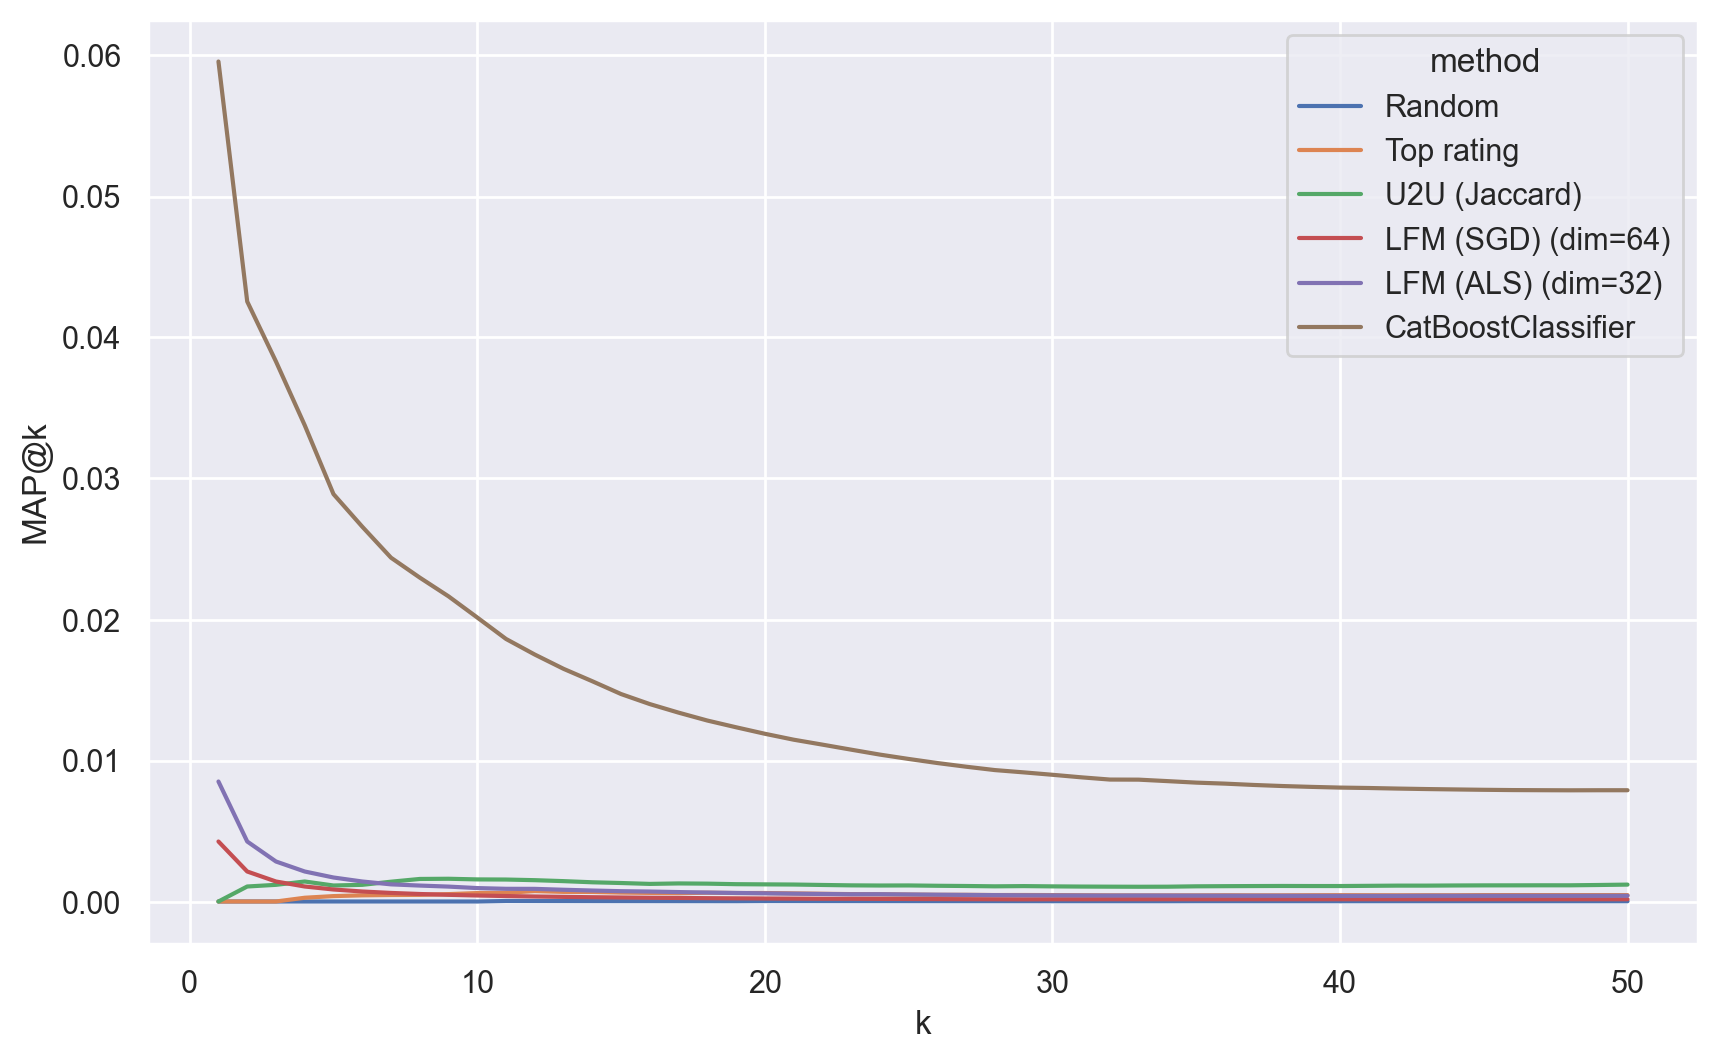

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, random_mapk, label='Random')
plt.plot(k_s, top_mapk, label='Top rating')
plt.plot(k_s, u2u_mapk, label='U2U (Jaccard)')
plt.plot(k_s, lfm_sgd_mapk, label='LFM (SGD) (dim=64)')
plt.plot(k_s, lfm_als_mapk, label='LFM (ALS) (dim=32)')
plt.plot(k_s, ctb_clf_mapk_all, label='CatBoostClassifier')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

In [63]:
df_metrics_best

,MAP@20
CatBoostClassifier,0.011896
U2U (Jaccard),0.001215
LFM (SGD),0.000213
LFM (ALS),0.000579


**Вывод**: `CatBoostClassifier`, переранжирующий кандидатов от моделей `User2User` и `LFM (ALS)`, работает на порядок лучше них — особенно при небольших `k`.

**Задание 12.**

Обучим `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделаем все те же действия, что и с `CatBoostClassifier` и сравним результаты.

In [64]:
from catboost import CatBoostRanker

In [70]:
# сортирую выборки по id юзеров, как этого требует CatBoostRanker
train_group_id_idx = np.argsort(X_train[:, 0])
test_group_id_idx = np.argsort(X_test[:, 0])

X_train_sort_by_id, X_test_sort_by_id = X_train[train_group_id_idx], X_test[test_group_id_idx]
y_train_sort_by_id, y_test_sort_by_id = y_train[train_group_id_idx], y_test[test_group_id_idx]

train_group_id, test_group_id = X_train_sort_by_id[:, 0].astype(int), X_test_sort_by_id[:, 0].astype(int)

train_pool_ranked = catboost.Pool(X_train_sort_by_id, y_train_sort_by_id, group_id=train_group_id)
test_pool_ranked = catboost.Pool(X_test_sort_by_id, y_test_sort_by_id, group_id=test_group_id)

В качестве функции ранжирования буду использовать `YetiRank` *в попарном режиме*. Авторы `catboost` утверждают, что она дает самое лучшее качество ранжирования, то же самое было сказано на лекции. Также будем смотреть на метрику MAP@20 при обучении.

In [163]:
ranker_model = CatBoostRanker(iterations=10_000, loss_function='YetiRankPairwise', custom_metric='MAP:top=20', random_seed=13)  # task_type='GPU'

In [164]:
ranker_model.fit(train_pool_ranked, eval_set=test_pool_ranked, plot=True, use_best_model=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9172444	best: 0.9172444 (0)	total: 37ms	remaining: 6m 10s
1:	test: 0.9229408	best: 0.9229408 (1)	total: 71ms	remaining: 5m 55s
2:	test: 0.9215265	best: 0.9229408 (1)	total: 109ms	remaining: 6m 4s
3:	test: 0.9378230	best: 0.9378230 (3)	total: 143ms	remaining: 5m 57s
4:	test: 0.9409421	best: 0.9409421 (4)	total: 173ms	remaining: 5m 45s
5:	test: 0.9412527	best: 0.9412527 (5)	total: 196ms	remaining: 5m 26s
6:	test: 0.9422420	best: 0.9422420 (6)	total: 226ms	remaining: 5m 22s
7:	test: 0.9455293	best: 0.9455293 (7)	total: 259ms	remaining: 5m 23s
8:	test: 0.9479602	best: 0.9479602 (8)	total: 287ms	remaining: 5m 18s
9:	test: 0.9499708	best: 0.9499708 (9)	total: 314ms	remaining: 5m 13s
10:	test: 0.9499708	best: 0.9499708 (9)	total: 398ms	remaining: 6m 1s
11:	test: 0.9506091	best: 0.9506091 (11)	total: 448ms	remaining: 6m 12s
12:	test: 0.9500665	best: 0.9506091 (11)	total: 481ms	remaining: 6m 9s
13:	test: 0.9489671	best: 0.9506091 (11)	total: 510ms	remaining: 6m 3s
14:	test: 0.9495096

Лучший результат по метрике MAP@20 был достингут на итерации 9633, по метрике PFound — на итерации 5735.

In [156]:
def make_re_ranking_for_rank_model(model, ntree_end, ntree_start=0):
    """
    Функция для переранжирования кандидатов для рекомендаций пользователю с помощью модели CatBoostRanker.
    Требует наличие у модели метода класса predict(), в котором должны быть аргументы ntree_start и ntree_end.
    """
    re_ranking = []

    for user_idx, user in tqdm_old(enumerate(test_users)):
        # достаем кандидатов для юзера
        candidates_for_user = candidates[user_idx, :]
        # оставляем только уникальные (две модели могут независимо выбрать одинаковых кандидатов)
        unique_candidates_for_user = np.unique(candidates_for_user)
        # достаем новые признаковые описания кандидатов
        X_for_user = X[X[:, 0] == user][unique_candidates_for_user]
        # считаем скор (логиты вхождения в последние 50 прослушанных треков)
        score_for_user = model.predict(X_for_user, ntree_start=ntree_start, ntree_end=ntree_end)  # logits
        # переранжируем кандидатов по скору, добавляем в общий список
        recomendations_for_user = unique_candidates_for_user[np.argsort(-score_for_user)]
        re_ranking.append(recomendations_for_user.tolist())

    return re_ranking

In [165]:
re_ranking_ctb_rank = make_re_ranking_for_rank_model(ranker_model, 9634)

235it [00:27,  8.44it/s]


In [167]:
mapk_20_ctb_rank = mapk(test_relevant, re_ranking_ctb_rank, k=20)
ctb_rank_mapk_all = [mapk(test_relevant, re_ranking_ctb_rank, k=k) for k in tqdm(k_s)]

  0%|          | 0/50 [00:00<?, ?it/s]

In [171]:
df_metrics_best.loc['CatBoostRanker'] = [mapk_20_ctb_rank]

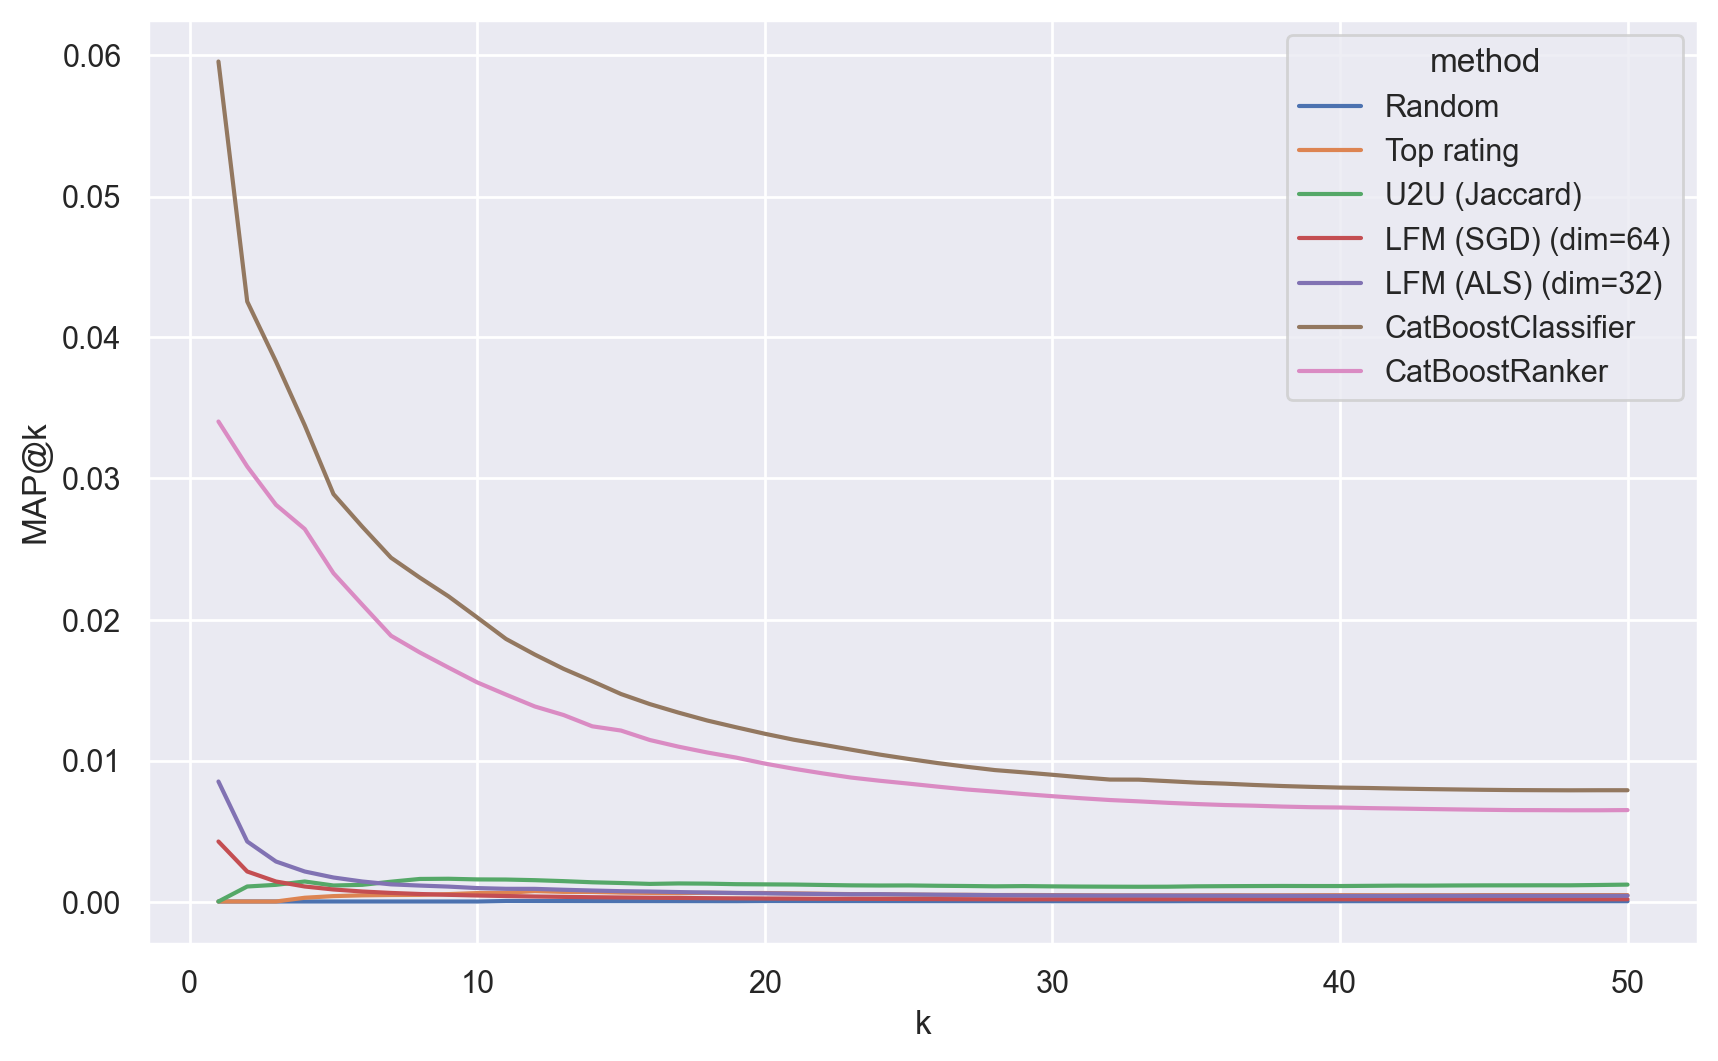

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(k_s, random_mapk, label='Random')
plt.plot(k_s, top_mapk, label='Top rating')
plt.plot(k_s, u2u_mapk, label='U2U (Jaccard)')
plt.plot(k_s, lfm_sgd_mapk, label='LFM (SGD) (dim=64)')
plt.plot(k_s, lfm_als_mapk, label='LFM (ALS) (dim=32)')
plt.plot(k_s, ctb_clf_mapk_all, label='CatBoostClassifier')
plt.plot(k_s, ctb_rank_mapk_all, label='CatBoostRanker')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

In [172]:
df_metrics_best.sort_values(by='MAP@20', ascending=False)

,MAP@20
CatBoostClassifier,0.011896
CatBoostRanker,0.009782
U2U (Jaccard),0.001215
LFM (ALS),0.000579
LFM (SGD),0.000213


**Итог:** `CatBoostClassifier` получил лучшее качество рекомендаций, чем `CatBoostRanker` для всех `k`. Думаю, это может быть связано с тем, что 1) есть только факты прослушивания песен пользователями — неявный фидбек по своей сути и 2) небольшой размер обучающей выборки (около 7 тыс.) с учетом того, что положительных примеров в целом мало.

В результате лучшее значение метрики MAP@20 — 0.011896 у `CatBoostClassifier`.